# INIT

In [ ]:
# ============================================================
# GOOGLE DRIVE PERSISTENCE (Colab only)
# ============================================================
# This cell MUST run first to redirect results/ to Drive
# before any other code writes to disk.
# On local machines, this is a no-op.

from pathlib import Path
import sys

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()))

from src.integration.colab_drive import is_colab, setup_drive_persistence

# === Configuration ===
USE_DRIVE = True       # Set False to use local storage only
KEEP_N_RUNS = 5        # Number of old runs to keep (rotation)

# === Setup ===
if is_colab() and USE_DRIVE:
    DRIVE_PATH = setup_drive_persistence(
        local_results_dir=Path("results/diagnostic_runs"),
        keep_n_runs=KEEP_N_RUNS
    )
    print(f"Drive persistence enabled")
    print(f"  Results folder: {DRIVE_PATH}")
    print(f"  Old runs kept: {KEEP_N_RUNS}")
else:
    DRIVE_PATH = None
    print("Local storage mode (results saved locally)")


In [ ]:
# ============================================================
# RESUME AFTER DISCONNECT (run this after reconnecting)
# ============================================================
# Skip this cell for normal execution.
# Only use when resuming after a Colab runtime disconnection.

# from src.integration.colab_drive import mount_drive, list_runs, get_latest_run
# from pathlib import Path

# # Remount Drive after disconnect
# mount_drive()

# # List available runs
# runs_dir = Path("/content/drive/MyDrive/latent_risk_factor/results/diagnostic_runs")
# print("Available runs:")
# for run in list_runs(runs_dir):
#     print(f"  {run['name']} - {run['size_mb']:.1f} MB - Stage: {run['last_stage']}")

# # Get latest run for resume
# latest = get_latest_run(runs_dir)
# if latest:
#     print(f"\nTo resume, set RUN_DIR = '{latest}'")
# else:
#     print("No runs found on Drive")


In [ ]:
!pip install .

# MOSEK license setup (MOSEK is installed via pip install .)
# Upload your mosek.lic file to Colab, then copy it:
!mkdir -p ~/mosek && cp mosek.lic ~/mosek/mosek.lic

In [ ]:
# !nvidia-smi

# VAE Latent Risk Factor - Pipeline Dashboard

Central configuration and execution notebook for the full walk-forward validation pipeline.

**Workflow:**
1. Configure all parameters (Sections 1-2)
2. Load data (Section 3)
3. Run pipeline (Section 4)
4. Inspect results (Sections 5-7)

---
## 1. Setup

In [28]:
import os
import sys
import logging
from dataclasses import replace, asdict
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Project root: go up from notebooks/ to project root
_NB_DIR = Path(os.path.abspath("")).resolve()
PROJECT_ROOT = (_NB_DIR / "..").resolve() if _NB_DIR.name == "notebooks" else _NB_DIR
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

from src.config import (
    PipelineConfig,
    DataPipelineConfig,
    VAEArchitectureConfig,
    LossConfig,
    TrainingConfig,
    InferenceConfig,
    RiskModelConfig,
    PortfolioConfig,
    WalkForwardConfig,
)
from src.data_pipeline.data_loader import load_data_source
from src.data_pipeline.returns import compute_log_returns
from src.data_pipeline.features import compute_trailing_volatility
from src.integration.pipeline import FullPipeline
from src.integration.reporting import export_results, format_summary_table
from src.integration.visualization import (
    plot_fold_metrics,
    plot_e_star_distribution,
    plot_pairwise_heatmap,
    style_summary_table,
    style_fold_table,
)
from src.utils import get_optimal_device
from src.walk_forward.selection import aggregate_fold_metrics, summary_statistics

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# force=True required in Colab/Jupyter where root logger is pre-configured
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s: %(message)s", force=True)
logger = logging.getLogger("dashboard")

print(f"PyTorch {torch.__version__} | Device: {get_optimal_device()}")
print(f"Working directory: {os.getcwd()}")

2026-02-24 11:17:52,148 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


PyTorch 2.10.0 | Device: mps
Working directory: /Users/mathis/1-Projects/Latent_risk_factor


---
## 2. Configuration

Two configuration profiles are available. **Run ONLY one section:**
- **Section 2a** — Synthetic data: minimal parameters for quick end-to-end testing
- **Section 2b** — Real data: full production configuration

Always run the **Global** cell (below) first, then choose ONE section.

In [29]:
# ============================================================
# GLOBAL
# ============================================================
SEED = 42
DEVICE = str(get_optimal_device())

# Data source: "synthetic", "tiingo", or "csv"
DATA_SOURCE = "tiingo"
QUICK_MODE = False          # Set True for minimal config even with real data
RUN_FULL_PIPELINE = False   # Set False to skip training and inference (useful for quick visualization)

# Pretrained model: set to a checkpoint path to skip VAE training and re-run only portfolio optimization
# Set to None to train from scratch
CHECKPOINT_PATH = None  # e.g. "checkpoints/checkpoint_direct_N200_Y10_T504_K200_F2.pt"

# Tiingo API keys (used when DATA_SOURCE = "tiingo")
TIINGO_API_KEYS = [
    "9ba6e57788deaac3b3c38ed47047cabbbd6077e2",
    "9aad315d49275c400687f41dd26b22328d8b1a26",
    "5d0dd679cc88f2a55c833b6e4ffd8d8d56fa0fc5",
    "66134d425322719f2465e1a021fa43c8054fe157",
    "1bc7a5bcd30f0d4e32137e92dc74f162da8d2424",
    "643fbd2e772679625edda7916feb0aaac7d5eb4a",
    "1d4af3a9a1ce6092fd6dd08ed95c702b6c63c934",
    "b9a4b731ee5ba3dd02bc09614613ee22e52a7c75",
    "3b2337b53147ba06aafe33122887ee143bd9ffdd",
    "561d65cdc9a7dddfd9d891522250bf40f25e9305",
    "cea76c53d7bafad468b98d32ea600eec2e104561",
    "e07dce0affdccd565f803a4152364515d2df7f78",
    "04b97f43d5ef1387395207f5d4388e8cf28fd5f8",
    "289f4878471f82cee0a533f49aa44bae080dce8f",
    "1b4e3c553ac4d6078395bdd55cd2f292222919d0",
    "0a4dd0e82339e617fff7fbb6d8e2affe11194aa8",
    "43455b994add9f54e6dc629399f851b007f2a038",
    "a27f7790680f379499ddfe1302ec68a3c9a75a74",
    "707f2f47875bb820471cff943a7462d91dcbf6ba",
    "4745d791cd7d08912015bf65edb12fbe256b3cda",
    "2a2fb9bc6a5d12c3097499a42bbb2afd76f538f4",
    "15627485874843399ce75d8e984a8c3473e83e65",
    "c9793a615c339d204454dbac332680fe25c5d471",
    "669f1bfa6a4b1b51042304af7daf6288f53ea88b",
    "ffa58b3d42c7b34547574e9318090067621c97d0",
    "2d18ed83dc9c9b5ea2faa284cdaf6188819cb2ac",
    "8bfe595273b49c7bafac292261c0e5670002202f",
    "7f5c957a4129d6bdc8644fc4832e8148828740b8",
    "fe353f2c950b8e03b4e83e569a0b129ede8e4d35",
    "3b1ba45faa5f00e1c6fce3beb905c043caefec26",
    "552b2ca3c474c9694dc417f95b5113175dfdbcce",
    "6460458e258d2a7f0fc0bb03bc94c2047ba82105",
    "3062157e1ace50ba07b2a4af9ee4bac16a369b39"
]
DATA_DIR = "data/"          # Directory for Tiingo downloaded data

2026-02-24 11:17:53,546 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


In [30]:
N_STOCKS = 4500                  #[⭐️] Top N stocks by median market cap (50=fast, 200=realistic, 0=all)
N_YEARS = 40                     #[⭐️] Years of history to keep
MIN_N_YEARS = 10                 # First fold trains on at least MIN_N_YEARS (shorter = unreliable model)
T = 504                          #[⭐️] Window length (trading days, ~2 years)
N_FEATURES = 2                   #[⭐️] Features per timestep (return + realized vol)
K = 75                           #[⭐️] Max latent factors the VAE can discover (only "active units" AU<=K are used)
LOSS_MODE = "P"                  # Loss mode: "P"=full ELBO with learned sigma^2, "F"=simplified with beta warmup, "A"=hybrid
CRISIS_OVERWEIGHTING = 3.0       #[⭐️] Crisis overweighting: crisis windows count 3x more in reconstruction loss
MAX_CO_MOVEMENT_WEIGHT = 0.5     #[⭐️] Max co-movement weight (0.5 = strong cross-sectional coherence signal)
LAMBDA_CS = 0.5                  #[⭐️] Cross-sectional R² loss weight (bridges temporal training to cross-sectional usage)
CS_N_SAMPLE_DATES = 20           # Number of time offsets sampled per batch for cross-sectional loss
FEATURE_WEIGHTS = [2.0, 0.5]     #[⭐️] Per-feature reconstruction weights: [returns, vol]. Emphasizes returns over volatility.

MAX_EPOCHS = 500                 #[⭐️] Max training epochs (early stopping may halt training sooner)
BATCH_SIZE = 512                 # Training batch size (windows)
LEARNING_RATE = 5e-3             # Adam learning rate
EARLY_STOPPING_PATIENCE = 20     #[⭐️] Early stopping patience (epochs without improvement)
ES_MIN_DELTA = 0.0               #[⭐️] Min ELBO improvement to count as progress (0=any improvement resets counter)
LR_PATIENCE = 30                 # Reduce LR after this many stagnant epochs (triggers before early stop)
LR_FACTOR = 0.75                 # LR reduction factor when plateau detected
DROPOUT = 0.2
TRAINING_STRIDE = 21             # Training window stride (21 = one window per month per stock, faster training)
COMPILE_MODEL = True             # torch.compile on CUDA/MPS (faster forward/backward, ~30s warmup)

AU_THRESHOLD = 0.01              # KL > 0.01 nats = dimension is "active" (below = unused, posterior ≈ prior)
AGGREGATION_METHOD = "mean"      # Method to aggregate overlapping window predictions ("mean", "median", etc.)
AGGREGATION_HALF_LIFE = 60       #[⭐️] Exponential decay half-life (in windows) for profile aggregation.
                                 # 0=uniform mean (legacy). 60=recent windows weighted ~5yr half-life at stride=21.
                                 # Higher = B_A reflects current market structure, lower = more stable/historical.

SIGMA_Z_EIGENVALUE_PCT = 0.95    #[⭐️] Keep top eigenvalues explaining 95% of Sigma_z variance.
                                 # 1.0=no truncation. <1.0=discard noisy factor dimensions.

B_A_SHRINKAGE_ALPHA = 0.0        #[⭐️] Shrink B_A towards zero: B_A *= (1 - alpha).
                                 # 0.0=no shrinkage (default). Z-scoring per-factor is sufficient
                                 # (Barra USE4). Uniform scaling is absorbed by variance targeting.

# --- Eigenvalue power shrinkage ---
# Compresses dominant eigenvalues to reduce factor concentration.
# eigenvalues = eigenvalues^p where p < 1 flattens the spectrum.
EIGENVALUE_POWER = 0.65          #[⭐️] 0.65=compress dominant eigenvalues, 1.0=off, 0.5=sqrt

HP_GRID = None                   # HP GRID for Phase A (set to None for default 18-config grid : 3 loss modes × 2 learning rates × 3 alphas = 18 configs)
                                 # Phase A tries all configs on nested validation to find the best HP set per fold
                
# Uncomment to define a custom grid (faster, but less thorough HP search):
# HP_GRID = [
#     {"mode": "P", "learning_rate": 5e-4, "alpha": 1.0},   # mode: loss formulation, alpha: risk-entropy tradeoff
#     {"mode": "F", "learning_rate": 1e-3, "alpha": 0.5},
#     {"mode": "A", "learning_rate": 1e-3, "alpha": 2.0},
# ]

In [31]:
# ============================================================
# Variance (w'Sigma w) = total portfolio risk. Minimizing it concentrates
# weight on low-vol stocks — but can put 85% of risk on 2-3 latent
# factors without noticing (fragile to factor shocks).
#
# Entropy H(w) = Shannon entropy on each factor's risk contribution.
# Maximizing it spreads risk evenly across all active factors — no
# single factor dominates (resilient to individual factor crashes).
#
# lambda_risk and alpha control the tradeoff: more lambda_risk favors
# low total variance; more alpha favors even factor risk distribution.
#
# lambda_risk guide (scales daily variance w'Sigma_daily w to the objective):
#   252  → annualized risk aversion gamma=1 (default, balanced)
#   504  → gamma=2 (conservative)
#   1260 → gamma=5 (near min-variance)
#   50   → gamma~0.2 (entropy-dominated, higher variance OK)
#
# Penalty tuning guide (defaults calibrated for US mid/large cap):
#   Illiquid universe (small caps) → raise kappa_1 & kappa_2
#   Infrequent rebalancing         → lower kappa_1 & kappa_2
#   Allow more concentrated bets   → raise w_bar or lower phi
#   Force tighter diversification  → lower w_bar or raise phi
#   Smoother trades                → lower delta_bar (e.g. 0.005)
#
# Valid ranges from DVT spec:
#   kappa_1: [0.01, 1.0]  kappa_2: [1, 50]  delta_bar: [0.005, 0.03]
# ============================================================

LAMBDA_RISK = 252.0              #[⭐️] Risk aversion (252=annualized gamma=1; higher = more conservative)

W_MAX = 0.03                     # Hard cap per stock (CVXPY constraint: w_i <= w_max)
W_MIN = 0.001                    # Min active weight: below this, stock is eliminated (0 or >= 0.1%)
W_BAR = 0.015                    # Soft cap: concentration penalty threshold (phi penalizes w_i > w_bar)

PHI = 15.0                       # Concentration penalty strength: phi * sum(max(0, w_i - w_bar)^2). 0=off, 5=moderate
KAPPA_1 = 0.1                    # Linear turnover penalty (penalizes trading costs at rebalance)
KAPPA_2 = 7.5                    # Quadratic turnover penalty (penalizes large trades more than small ones)
DELTA_BAR = 0.01                 # Turnover below 1% is not penalized (de minimis threshold)
MAX_TURNOVER = 0.30              #[⭐️] Max 30% turnover per rebalance (prevents excessive trading costs)

# ============================================================
# OOS REBALANCING (DVT §4.2)
# ============================================================
REBALANCING_FREQUENCY = 63       #[⭐️] Days between rebalancing (0 = buy-and-hold, 21 = monthly, 63 = quarterly)
ENTROPY_TRIGGER_ALPHA = 0.90     # Exceptional rebalancing if H drops below 90% of last rebalancing H

ALPHA_GRID = [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]  #[⭐️] 12-point grid for reliable Kneedle elbow detection

SCA_N_STARTS = 5                 # Multi-start optimizations (more = better optimum, proportionally slower)

# --- Entropy gradient normalization (Phase 14, Finding 1) ---
# Rescales entropy gradient to match risk gradient magnitude at each SCA iteration.
# Without this, entropy dominates risk ~700:1, making the optimizer a pure entropy maximizer.
NORMALIZE_ENTROPY_GRADIENT = True  #[⭐️] True = balance entropy/risk gradients (recommended)

# --- Entropy budget mode (Phase 14, Finding 2) ---
# "proportional" = tilted entropy with budget b_k = lambda_k / sum(lambda)
#   Targets risk contributions proportional to eigenvalues (respects spectral structure)
# "uniform" = standard Shannon entropy (equal risk contributions across factors)
ENTROPY_BUDGET_MODE = "proportional"  #[⭐️] "proportional" (recommended) or "uniform"

# --- Cross-sectional momentum (expected return signal) ---
# Jegadeesh & Titman (1993): 12-month cumulative return minus last month,
# z-scored cross-sectionally. Set MOMENTUM_ENABLED=True to activate.
MOMENTUM_ENABLED = True           #[⭐️] Toggle: True = use momentum signal mu, False = pure risk budgeting (mu=0)
MOMENTUM_LOOKBACK = 252           # Lookback window in trading days (~12 months)
MOMENTUM_SKIP = 21                # Skip last month (avoids short-term reversal)
MOMENTUM_WEIGHT = 0.30            #[⭐️] Scaling factor for momentum signal (gamma_mom)

### Parameters details


#### Data Pipeline Parameters

| Parameter | What it controls |
|---|---|
| `n_stocks` | Universe size — how many stocks to keep (ranked by market cap). More = better diversification, slower training. |
| `window_length` | Length of each input window in trading days. 504 ≈ 2 years of daily data. Each stock produces many overlapping windows. |
| `n_features` | Features per timestep. 2 = log-return + realized volatility. |
| `vol_window` | Lookback (trading days) for trailing volatility computation. 252 ≈ 1 year. |
| `vix_lookback_percentile` | VIX percentile above which a day is labeled "crisis". Higher = fewer crisis days = less overweighting. |
| `min_valid_fraction` | Minimum fraction of non-missing data to keep a stock. 0.80 = stocks missing >20% of their history are dropped. |

#### VAE Architecture Parameters

| Parameter | What it controls |
|---|---|
| `K` | Maximum latent capacity — how many risk factors the VAE *can* learn. Only "active units" (AU ≤ K) are actually used. Typical: 100-200. |
| `sigma_sq_init` | Starting value of learned observation noise σ². 1.0 = assume noise equals signal at first. The model learns the true value during training (Mode P/A). |
| `sigma_sq_min` / `sigma_sq_max` | Clamp bounds for σ². Prevents extreme values: too small = overfitting (model claims perfect reconstruction), too large = underfitting (model gives up). |
| `window_length` / `n_features` | Must match DataPipelineConfig — determines input tensor shape (T×F). |
| `r_max` | Maximum ratio of model parameters to data points. Safety guard — if the CNN has more parameters than the data can support, training is rejected. Relaxed automatically for small universes. |

#### Loss Function Parameters

| Parameter | What it controls |
|---|---|
| `mode` | Loss formulation. **P** = full probabilistic ELBO with learned σ² (recommended). **F** = simplified with β warmup, σ² frozen at 1.0 (use if Mode P diverges). **A** = hybrid with tunable KL weight β. |
| `gamma` | Crisis overweighting factor. 3.0 = windows falling in crisis periods (high VIX) count 3× more in reconstruction loss. Forces the model to learn crisis dynamics well. |
| `lambda_co_max` | Maximum co-movement loss weight. Controls how strongly latent distances must match stock Spearman correlations. Active during Phases 1-2, decays to 0 in Phase 3. |
| `beta_fixed` | Fixed KL weight for Mode A (must be 1.0 for Mode P). Values <1 reduce regularization pressure, giving more freedom to reconstruction. |
| `warmup_fraction` | Fraction of training where β ramps 0→1 (Mode F only). Prevents posterior collapse by letting the model learn to reconstruct before enforcing KL regularization. |
| `max_pairs` | Max stock pairs sampled per batch for co-movement loss. Limits compute cost — full pairwise is O(B²). |
| `delta_sync` | Maximum date gap (calendar days) for windows to be "synchronized" in the same time block. 21 ≈ 1 month. Ensures co-movement comparisons are temporally valid. |

#### Training Parameters

| Parameter | What it controls |
|---|---|
| `max_epochs` | Hard limit on training duration. Training may stop earlier via early stopping. |
| `batch_size` | Windows per gradient update. Larger = smoother gradients but more memory. 512 is a good default on A100. |
| `learning_rate` | Initial optimizer step size (η₀). Too high → loss diverges. Too low → converges very slowly. Typical: 1e-4 to 1e-3. |
| `weight_decay` | L2 regularization on model weights. Penalizes large weights to reduce overfitting. 1e-5 is mild. |
| `adam_betas` / `adam_eps` | Adam optimizer internals (momentum and numerical stability). Rarely need tuning. |
| `patience` | **Early stopping** — if validation ELBO doesn't improve for this many consecutive epochs, stop training and restore the best checkpoint. |
| `lr_patience` | **LR reduction** — if validation stagnates for this many epochs, multiply LR by `lr_factor`. Triggers before early stopping. |
| `lr_factor` | LR reduction multiplier. 0.5 = halve the learning rate each time it triggers. |
| `n_strata` | Number of volatility-based groups for stratified batching (Phases 1-2). Ensures each batch contains stocks from all risk profiles, not just one cluster. |
| `curriculum_phase1_frac` | Fraction of epochs for Phase 1 (co-movement at full strength + synchronized batching). |
| `curriculum_phase2_frac` | Fraction of epochs for Phase 2 (co-movement linearly decaying). Phase 3 = remainder (free refinement, random batching). |
| `training_stride` | Window stride for training data. 21 = one window per month per stock (21× fewer windows, much faster). Inference always uses stride=1. |
| `compile_model` | Enable `torch.compile` on CUDA/MPS for faster forward/backward passes. ~30s warmup cost, then ~20-40% speedup. |

#### Inference Parameters

| Parameter | What it controls |
|---|---|
| `batch_size` | Batch size for inference pass. Can be larger than training (no gradients stored = less memory). |
| `au_threshold` | KL threshold in nats to consider a latent dimension "active". 0.01 is standard — dimensions with KL < 0.01 are effectively unused (posterior ≈ prior). |
| `r_min` | Minimum observations-per-parameter ratio. Caps AU_max = ⌊√(2·N_obs/r_min)⌋ to prevent more active factors than the data can reliably estimate. |
| `aggregation_method` | How to combine predictions from overlapping windows for the same stock. "mean" averages all windows. |

#### Risk Model Parameters

| Parameter | What it controls |
|---|---|
| `winsorize_lo` / `winsorize_hi` | Percentile bounds for clipping extreme volatility ratios during rescaling. [5, 95] = trim the 5% most extreme values on each side. |
| `d_eps_floor` | Minimum idiosyncratic (stock-specific) variance. Prevents division by zero when a stock has near-zero residual risk. |
| `conditioning_threshold` | If the covariance matrix condition number exceeds this, the factor regression switches to ridge regression for numerical stability. |
| `ridge_scale` | Ridge regularization strength when the fallback activates. Small value (1e-6) = minimal regularization, just enough to stabilize. |


#### Portfolio Optimization Parameters

| Parameter | What it controls |
|---|---|
| `lambda_risk` | Risk aversion. Higher = portfolio avoids variance more aggressively, at the cost of lower expected return. |
| `w_max` | Hard cap per stock. 0.05 = no stock can exceed 5% of the portfolio. |
| `w_min` | Minimum active weight. Stocks allocated below this are eliminated entirely (semi-continuous: either 0 or ≥ w_min). |
| `w_bar` | Concentration penalty threshold. Stocks above this weight get penalized to encourage diversification. |
| `phi` | Concentration penalty strength. Higher = more aggressively pushes weights below w_bar. |
| `kappa_1` / `kappa_2` | Linear and quadratic turnover penalties. Penalize trading costs when rebalancing. Higher = more stable portfolio across rebalances. |
| `delta_bar` | Turnover penalty threshold — small weight changes below this are not penalized. |
| `tau_max` | Maximum one-way turnover per rebalance. 0.30 = at most 30% of the portfolio can change in a single rebalance. |
| `n_starts` | Multi-start initializations for the SCA optimizer. More starts = higher chance of finding the global optimum, but proportionally slower. |
| `sca_max_iter` / `sca_tol` | SCA (Sequential Convex Approximation) iteration limit and convergence tolerance. |
| `armijo_*` | Line search parameters (sufficient decrease, backtracking factor, max steps). Controls step size selection within SCA. |
| `max_cardinality_elim` | Maximum rounds of sequential stock elimination to enforce the minimum weight constraint. |
| `entropy_eps` | Tiny constant (1e-30) added inside log() to avoid log(0). Pure numerical safety. |
| `alpha_grid` | Grid of α values for the variance-entropy frontier. The optimizer tries each α and picks the best tradeoff between risk and factor diversification. |


#### Walk-Forward Validation Parameters

| Parameter | What it controls |
|---|---|
| `total_years` | Total history length used for the walk-forward. More years = more folds = more robust evaluation, but requires more data. |
| `min_training_years` | Minimum training window. The first fold starts with this many years of training data. Too small = unreliable model, too large = few folds. |
| `oos_months` | Out-of-sample test period per fold. After training, the portfolio is tested on this many months, then the window slides forward. |
| `embargo_days` | Gap (trading days) between training end and OOS start. Prevents information leakage from overlapping windows near the boundary. 21 ≈ 1 month. |
| `holdout_years` | Final holdout period excluded from all training/testing. Reserved for ultimate out-of-sample validation. |
| `val_years` | Nested validation window within training for Phase A hyperparameter selection. Used to score HP configs without touching OOS data. |
| `score_lambda_pen` | Weight of maximum drawdown penalty in the composite HP scoring function. Higher = favor configs with lower drawdowns. |
| `score_lambda_est` | Weight of estimation quality penalty (variance ratio) in scoring. Higher = favor configs with more accurate risk predictions. |
| `score_mdd_threshold` | Maximum drawdown threshold. Drawdowns beyond this are heavily penalized in the composite score. |

### 2a. Quick Mode

Run **only this cell** to configure the pipeline for a minimal end-to-end test. Skip Section 2b entirely.

In [32]:
# ============================================================
# QUICK MODE — Minimal config for end-to-end testing
# Run ONLY this cell, then jump to Section 3
# ============================================================

if QUICK_MODE == True or DATA_SOURCE == "synthetic":
    DATA_PATH = ""
    N_STOCKS = 50   # How many stocks in the universe (ranked by market cap)
    N_YEARS = 20    # Years of history to use

    config = PipelineConfig(
        data=DataPipelineConfig(
            n_stocks=N_STOCKS,       # Universe size (top N by market cap)
            window_length=504,       # Input window = 504 trading days (~2 years)
            n_features=2,            # 2 features per timestep: log-return + realized vol
            training_stride=TRAINING_STRIDE,  # Window stride for training (21 = monthly, 1 = daily)
        ),
        vae=VAEArchitectureConfig(
            K=100,                   # Max latent factors the VAE can discover (only AU will be active)
            window_length=504,       # Must match data window_length
            n_features=2,            # Must match data n_features
            r_max=5.0,               # Max param/data ratio (relaxed for small universes, auto-adjusted)
        ),
        loss=LossConfig(
            mode="P",                # "P" = full probabilistic ELBO with learned observation noise sigma^2
        ),
        training=TrainingConfig(
            max_epochs=50,           # Hard limit on training (early stopping may trigger sooner)
            batch_size=512,          # Windows per gradient update (512 = good balance speed/stability)
            learning_rate=1e-4,      # Initial optimizer step size (typical: 1e-4 to 1e-3)
            patience=30,             # Stop if validation doesn't improve for 30 epochs
            compile_model=COMPILE_MODEL,  # torch.compile on CUDA/MPS
        ),
        inference=InferenceConfig(),   # Defaults: batch_size=512, au_threshold=0.01, r_min=2
        risk_model=RiskModelConfig(),  # Defaults: winsorize=[5,95], cond_threshold=1e6, ridge=1e-6
        portfolio=PortfolioConfig(
            n_starts=2,              # Multi-start optimizations (2 = fast, 5+ = production)
        ),
        walk_forward=WalkForwardConfig(
            total_years=N_YEARS,             # Total history for walk-forward folds
            min_training_years=max(3, N_YEARS // 3),  # Min training window (>=3y for reliability)
            holdout_years=max(1, N_YEARS // 5),       # Final holdout excluded from all folds (>=1y)
        ),
        seed=SEED,
    )

    # Single HP config (skip Phase A grid search for speed)
    HP_GRID = [{"mode": "P", "learning_rate": 1e-4, "alpha": 1.0}]

    print(f"[Quick mode] {N_STOCKS} stocks, {N_YEARS} years, K={config.vae.K}")
    print(f"  max_epochs={config.training.max_epochs}, patience={config.training.patience}, HP_GRID=1 config, n_starts=2")
    print(f"  r_max={config.vae.r_max:.0e}, training_stride={config.data.training_stride}, compile={config.training.compile_model}")
    print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
        f"{config.walk_forward.min_training_years}y min training, "
        f"{config.walk_forward.holdout_years}y holdout")
    print(f"  Device: {DEVICE}")

### 2b. Real Data (Production)

Run **all cells below** (through "ASSEMBLE FULL CONFIG") for full production configuration. Skip Section 2a.

In [33]:
# ============================================================
# DATA SOURCE — Real data
# ============================================================
# For CSV source:
DATA_PATH = "data/stock_data.csv"  # <-- Set path to your stock data CSV

# For Tiingo source: run download first:
#   python scripts/download_tiingo.py --phase all --keys-file keys.txt
# Then set DATA_SOURCE = "tiingo" in Global cell above.

#### Data Pipeline Parameters

| Parameter | What it controls |
|---|---|
| `n_stocks` | Universe size — how many stocks to keep (ranked by market cap). More = better diversification, slower training. |
| `window_length` | Length of each input window in trading days. 504 ≈ 2 years of daily data. Each stock produces many overlapping windows. |
| `n_features` | Features per timestep. 2 = log-return + realized volatility. |
| `vol_window` | Lookback (trading days) for trailing volatility computation. 252 ≈ 1 year. |
| `vix_lookback_percentile` | VIX percentile above which a day is labeled "crisis". Higher = fewer crisis days = less overweighting. |
| `min_valid_fraction` | Minimum fraction of non-missing data to keep a stock. 0.80 = stocks missing >20% of their history are dropped. |

In [34]:
# ============================================================
# DATA PIPELINE (MOD-001)
# ============================================================
data_cfg = DataPipelineConfig(
    n_stocks=N_STOCKS,           # universe cap (same as N_STOCKS above)
    window_length=T,             # T: sliding window length (trading days)
    n_features=N_FEATURES,       # F: features per timestep (return + realized vol)
    vol_window=252,              # trailing vol lookback (days)
    vix_lookback_percentile=80.0,# VIX percentile for crisis threshold
    min_valid_fraction=0.80,     # Drop stocks missing >20% of their price history
    training_stride=TRAINING_STRIDE,  # Window stride for training (21 = monthly, 1 = daily; inference always uses stride=1)
)

In [35]:
# ============================================================
# VAE ARCHITECTURE (MOD-002)
# ============================================================
vae_cfg = VAEArchitectureConfig(
    K=K,                                   # Max latent factors the VAE can discover (only "active units" AU<=K are used)
    sigma_sq_init=1.0,                     # Initial observation noise (1.0 = assume noise = signal, model learns true value)
    sigma_sq_min=1e-4,                     # Lower clamp for sigma^2 (prevents overfitting: model can't claim 0 noise)
    sigma_sq_max=10.0,                     # Upper clamp for sigma^2 (prevents divergence: model can't give up entirely)
    window_length=data_cfg.window_length,  # Must match data_cfg.window_length
    n_features=data_cfg.n_features,        # Must match data_cfg.n_features
    r_max=5.0,                             # Max model params / data points ratio (safety guard against overfitting)
    dropout=DROPOUT,                           # Dropout rate for VAE residual blocks (0.1=standard, 0.2=reinforced for small universes)
)

print(f"Encoder depth L={vae_cfg.encoder_depth}, "
      f"Final width C_L={vae_cfg.final_layer_width}, "
      f"D={vae_cfg.D}")

Encoder depth L=5, Final width C_L=384, D=1008


In [36]:
# ============================================================
# LOSS FUNCTION (MOD-004)
# ============================================================
loss_cfg = LossConfig(
    mode=LOSS_MODE,                        # Loss mode: "P"=full ELBO with learned sigma^2, "F"=simplified with beta warmup, "A"=hybrid
    gamma=CRISIS_OVERWEIGHTING,            # Crisis overweighting: crisis windows count 3x more in reconstruction loss
    lambda_co_max=MAX_CO_MOVEMENT_WEIGHT,  # Max co-movement weight: how strongly latent distances must match Spearman correlations
    beta_fixed=1.0,                        # Fixed KL weight for Mode A (must be 1.0 for Mode P)
    warmup_fraction=0.20,                  # Mode F only: fraction of epochs to ramp beta 0->1 (prevents posterior collapse)
    max_pairs=2048,                        # Max stock pairs per batch for co-movement loss (limits O(B^2) compute)
    delta_sync=21,                         # Max date gap (days) for windows to be "synchronized" (21 ≈ 1 month)
    lambda_cs=LAMBDA_CS,                   # Cross-sectional R² loss weight (forces encoder to produce useful factor exposures)
    cs_n_sample_dates=CS_N_SAMPLE_DATES,   # Time offsets sampled per batch for cross-sectional loss
    feature_weights=FEATURE_WEIGHTS,       # Per-feature reconstruction weights [returns, vol] (addresses 10× reconstruction imbalance)
)

In [37]:
# ============================================================
# TRAINING (MOD-005)
# ============================================================
training_cfg = TrainingConfig(
    max_epochs=MAX_EPOCHS,            # Hard limit on training duration (early stopping usually triggers sooner)
    batch_size=BATCH_SIZE,            # Windows per gradient step (larger = smoother but more memory)
    learning_rate=LEARNING_RATE,      # Initial optimizer step size (too high = diverges, too low = slow)
    weight_decay=1e-5,                # L2 penalty on weights to reduce overfitting (1e-5 = mild)
    adam_betas=(0.9, 0.999),          # Adam momentum parameters (rarely need tuning)
    adam_eps=1e-8,                    # Adam numerical stability constant (rarely need tuning)
    patience=EARLY_STOPPING_PATIENCE, # Early stopping: stop after N epochs without sufficient improvement
    es_min_delta=ES_MIN_DELTA,        # Min ELBO drop to count as improvement (higher = stops sooner)
    lr_patience=LR_PATIENCE,          # Reduce LR if validation stagnates for N epochs (triggers before early stop)
    lr_factor=LR_FACTOR,              # LR multiplier when reducing (0.75 = reduce by 25% each time)
    n_strata=15,                      # Volatility groups for stratified batching (ensures risk diversity per batch)
    curriculum_phase1_frac=0.40,      # Phase 1: 40% of epochs with full co-movement + synchronized batching
    curriculum_phase2_frac=0.30,      # Phase 2: 30% of epochs with co-movement linearly decaying to 0
                                      # Phase 3: remaining 30% with no co-movement, random batching
    compile_model=COMPILE_MODEL,      # torch.compile on CUDA/MPS (faster forward/backward, ~30s warmup)
)

In [38]:
# ============================================================
# INFERENCE (MOD-006)
# After training, the encoder runs on all windows to extract each stock's
# latent profile. These parameters control that extraction pass and
# decide how many latent dimensions are kept as "active" risk factors.
# ============================================================
inference_cfg = InferenceConfig(
    batch_size=512,                          # Larger than training (no gradients = less memory needed)
    au_threshold=AU_THRESHOLD,               # KL > 0.01 nats = dimension is "active" (below = unused, posterior ≈ prior)
    r_min=2,                                 # Min data/param ratio — caps AU_max to prevent more factors than data supports
    aggregation_method=AGGREGATION_METHOD,   # Average overlapping window predictions for each stock's final profile
    aggregation_half_life=AGGREGATION_HALF_LIFE,  # Exponential decay: 0=uniform, 60=recent windows weighted (~5yr half-life)
)

In [39]:
# ============================================================
# RISK MODEL (MOD-007)
# Transforms latent exposures (B matrix) into a full covariance
# matrix Sigma_assets via cross-sectional regression and
# Ledoit-Wolf shrinkage. These parameters handle numerical
# edge cases (extreme vol ratios, ill-conditioned matrices).
# ============================================================
risk_model_cfg = RiskModelConfig(
    winsorize_lo=5.0,            # Clip extreme vol ratios below 5th percentile (removes outliers)
    winsorize_hi=95.0,           # Clip extreme vol ratios above 95th percentile
    d_eps_floor=1e-6,            # Min idiosyncratic variance per stock (prevents division by zero)
    conditioning_threshold=1e6,  # Switch to ridge regression if covariance condition number exceeds this
    ridge_scale=1e-6,            # Ridge regularization strength (tiny, just enough to stabilize)
    sigma_z_eigenvalue_pct=SIGMA_Z_EIGENVALUE_PCT,  # Keep top eigenvalues explaining X% of Sigma_z variance (1.0=all)
    b_a_shrinkage_alpha=B_A_SHRINKAGE_ALPHA,  # Shrink B_A towards zero (0.0=off, 0.1=10% shrinkage)
    au_max_bai_ng_factor=1.0,    # Post-filter AU using Bai-Ng IC2 bound (1.0=exact, 1.5=50% slack, 0=disabled)
    vt_clamp_min=0.5,            # VT clamp: min scale factor (prevents pro-cyclical VT from halving eigenvalues)
    vt_clamp_max=2.0,            # VT clamp: max scale factor (limits over-correction during calm periods)
)

In [40]:
# ============================================================
# PORTFOLIO OPTIMIZATION (MOD-008)
# Constraints identical for VAE and all 6 benchmarks (INV-012)
#
# Variance (w'Σw) = total portfolio risk. Minimizing it concentrates
# weight on low-vol stocks — but can put 85% of risk on 2-3 latent
# factors without noticing (fragile to factor shocks).
#
# Entropy H(w) = Shannon entropy on each factor's risk contribution.
# Maximizing it spreads risk evenly across all active factors — no
# single factor dominates (resilient to individual factor crashes).
#
# lambda_risk and alpha control the tradeoff: more lambda_risk favors
# low total variance; more alpha favors even factor risk distribution.
#
# lambda_risk guide:
#   0.1  → entropy dominates (pure factor risk parity, higher variance OK)
#   0.5  → entropy favored, soft variance constraint
#   1.0  → balanced (default, let alpha_grid find the right ratio)
#   2.0  → variance favored (more conservative, fewer dominant factors OK)
#   5.0+ → near min-variance (entropy has little influence)
#
# Penalty tuning guide (defaults calibrated for US mid/large cap):
#   Illiquid universe (small caps) → raise kappa_1 & kappa_2
#   Infrequent rebalancing         → lower kappa_1 & kappa_2
#   Allow more concentrated bets   → lower phi and/or raise w_bar
#   Force tighter diversification  → raise phi and/or lower w_bar
#   Smoother trades                → lower delta_bar (e.g. 0.005)
#
# Valid ranges from DVT spec:
#   phi: [5, 100]  kappa_1: [0.01, 1.0]  kappa_2: [1, 50]  delta_bar: [0.005, 0.03]
# ============================================================
portfolio_cfg = PortfolioConfig(
    lambda_risk=LAMBDA_RISK,     # Risk aversion (higher = more conservative, lower variance portfolio)
    w_max=W_MAX,                 # Hard cap per stock (CVXPY constraint: w_i <= w_max)
    w_min=W_MIN,                 # Min active weight: below this, stock is eliminated (0 or >= 0.1%)
    w_bar=W_BAR,                 # Soft cap: concentration penalty kicks in above this weight
    phi=PHI,                     # Concentration penalty strength above w_bar (phi * sum(max(0, w_i - w_bar)^2))
    kappa_1=KAPPA_1,             # Linear turnover penalty (penalizes trading costs at rebalance)
    kappa_2=KAPPA_2,             # Quadratic turnover penalty (penalizes large trades more than small ones)
    delta_bar=DELTA_BAR,         # Turnover below 1% is not penalized (de minimis threshold)
    tau_max=MAX_TURNOVER,        # Max 30% portfolio change per rebalance (hard cap on turnover)
    n_starts=SCA_N_STARTS,       # Multi-start optimizations (more = better optimum, proportionally slower)
    sca_max_iter=300,            # Max iterations for the SCA convex optimizer
    sca_tol=1e-8,                # SCA convergence tolerance (stop when improvement < this)
    armijo_c=1e-4,               # Line search: sufficient decrease constant
    armijo_rho=0.5,              # Line search: backtracking factor (halve step on each retry)
    armijo_max_iter=20,          # Line search: max backtracking attempts per SCA step
    max_cardinality_elim=100,    # Max rounds of stock elimination to enforce w_min constraint
    entropy_eps=1e-30,           # Tiny constant in log() for numerical safety (avoids log(0))
    alpha_grid=ALPHA_GRID,       # Risk-entropy tradeoff grid (optimizer picks best alpha)
    normalize_entropy_gradient=NORMALIZE_ENTROPY_GRADIENT,  # Balance entropy/risk gradient scales
    entropy_budget_mode=ENTROPY_BUDGET_MODE,                # "proportional" or "uniform" entropy target
    momentum_enabled=MOMENTUM_ENABLED,    # Toggle momentum signal (True/False)
    momentum_lookback=MOMENTUM_LOOKBACK,  # 12-month lookback (trading days)
    momentum_skip=MOMENTUM_SKIP,          # Skip last month (reversal)
    momentum_weight=MOMENTUM_WEIGHT,      # Scaling factor for momentum signal
    # OOS Rebalancing (DVT §4.2)
    rebalancing_frequency_days=REBALANCING_FREQUENCY,  # Days between rebalancing (0=buy-hold)
    entropy_trigger_alpha=ENTROPY_TRIGGER_ALPHA,       # Exceptional trigger threshold
)

In [41]:
# ============================================================
# WALK-FORWARD VALIDATION (MOD-009)
# ============================================================
walk_forward_cfg = WalkForwardConfig(
    total_years=N_YEARS,            # Total history used (more years = more folds = more robust evaluation)
    min_training_years=MIN_N_YEARS, # First fold trains on at least MIN_N_YEARS (shorter = unreliable model)
    oos_months=6,                   # Test each fold on 6 months out-of-sample, then slide forward
    embargo_days=21,                # 21-day gap between training and test (prevents data leakage from windows)
    holdout_years=3,                # Last 3 years excluded from all folds (final out-of-sample validation)
    val_years=2,                    # 2-year nested validation within training for HP selection (Phase A)
    score_lambda_pen=5.0,           # HP scoring: penalty weight for max drawdown (higher = favor low-drawdown configs)
    score_lambda_est=2.0,           # HP scoring: penalty weight for poor risk estimation accuracy
    score_mdd_threshold=0.20,       # HP scoring: drawdowns above 20% get heavily penalized
)

In [42]:
# ============================================================
# ASSEMBLE FULL CONFIG
# ============================================================
if DATA_SOURCE != "synthetic" and QUICK_MODE == False:
      config = PipelineConfig(
            data=data_cfg,
            vae=vae_cfg,
            loss=loss_cfg,
            training=training_cfg,
            inference=inference_cfg,
            risk_model=risk_model_cfg,
            portfolio=portfolio_cfg,
            walk_forward=walk_forward_cfg,
            seed=SEED,
      )

      print("PipelineConfig assembled.")
      print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
            f"{config.walk_forward.min_training_years}y min training, "
            f"{config.walk_forward.holdout_years}y holdout")
      print(f"  VAE: K={config.vae.K}, T={config.vae.window_length}, F={config.vae.n_features}")
      print(f"  Training: {config.training.max_epochs} max epochs, "
            f"bs={config.training.batch_size}, lr={config.training.learning_rate}")
      print(f"  Loss mode: {config.loss.mode}, gamma={config.loss.gamma}")
      print(f"  Capacity guard r_max: {config.vae.r_max}")
      print(f"  Device: {DEVICE}")

PipelineConfig assembled.
  Walk-forward: 40y total, 10y min training, 3y holdout
  VAE: K=75, T=504, F=2
  Training: 500 max epochs, bs=512, lr=0.005
  Loss mode: P, gamma=3.0
  Capacity guard r_max: 5.0
  Device: mps


---
## 3. Data Loading

### 3a. Tiingo Download (run once)

Run this cell **only once** to download Tiingo data. After the first run, the data is saved locally and reused automatically.
Set `MAX_TICKERS` to a small number (e.g. 5) for testing, or `None` for the full universe.

In [16]:
# ============================================================
# TIINGO DOWNLOAD — Run once, data is saved locally
# Skip this cell if data is already downloaded or DATA_SOURCE != "tiingo"
# ============================================================

if DATA_SOURCE == "tiingo":
    import importlib.util

    _spec = importlib.util.spec_from_file_location(
        "download_tiingo", str(PROJECT_ROOT / "scripts" / "download_tiingo.py")
    )
    _mod = importlib.util.module_from_spec(_spec)
    _spec.loader.exec_module(_mod)  # type: ignore[union-attr]

    MAX_TICKERS = None  # Set to None for full universe (~22k tickers)

    _mod.run_download(
        api_keys=TIINGO_API_KEYS,
        data_dir=DATA_DIR,
        max_tickers=MAX_TICKERS,
        sp500_first=True,  # Download SP500 tickers first (priority)
    )
else:
    print(f"DATA_SOURCE={DATA_SOURCE}, skipping Tiingo download.")

2026-02-24 09:54:38,721 [INFO] download_tiingo: Validating 33 API key(s)...
2026-02-24 09:54:39,166 [INFO] download_tiingo: Key #1 valid (masked: ...77e2)
2026-02-24 09:54:39,497 [INFO] download_tiingo: Key #2 valid (masked: ...1a26)
2026-02-24 09:54:39,802 [INFO] download_tiingo: Key #3 valid (masked: ...0fc5)
2026-02-24 09:54:40,114 [INFO] download_tiingo: Key #4 valid (masked: ...e157)
2026-02-24 09:54:40,418 [INFO] download_tiingo: Key #5 valid (masked: ...2424)
2026-02-24 09:54:40,746 [INFO] download_tiingo: Key #6 valid (masked: ...eb4a)
2026-02-24 09:54:41,068 [INFO] download_tiingo: Key #7 valid (masked: ...c934)
2026-02-24 09:54:41,383 [INFO] download_tiingo: Key #8 valid (masked: ...7c75)
2026-02-24 09:54:41,692 [INFO] download_tiingo: Key #9 valid (masked: ...ffdd)
2026-02-24 09:54:41,993 [INFO] download_tiingo: Key #10 valid (masked: ...9305)
2026-02-24 09:54:42,323 [INFO] download_tiingo: Key #11 valid (masked: ...4561)
2026-02-24 09:54:42,642 [INFO] download_tiingo: Key #

KeyboardInterrupt: 

In [17]:
np.random.seed(SEED)

stock_data, start_date = load_data_source(
    source=DATA_SOURCE,
    data_path=DATA_PATH if DATA_SOURCE == "csv" else "",
    data_dir=DATA_DIR,
    n_stocks=N_STOCKS,
    n_years=N_YEARS,
    seed=SEED,
)

print(f"Data source: {DATA_SOURCE}")
print(f"Stock data shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print(f"Unique stocks: {stock_data['permno'].nunique()}")
stock_data.head()

Data source: tiingo
Stock data shape: (16857625, 8)
Date range: 1995-01-03 00:00:00 to 2026-02-20 00:00:00
Unique stocks: 4500


,permno,date,adj_price,volume,exchange_code,share_code,market_cap,delisting_return
0,10003,2018-08-22,19.626813,611551,1,10,3.055309e+08,NaN
1,10003,2018-08-23,19.595385,504340,1,10,2.783032e+08,NaN
2,10003,2018-08-24,19.618956,399908,1,10,2.523300e+08,NaN
3,10003,2018-08-27,19.626813,432343,1,10,2.433229e+08,NaN
4,10003,2018-08-28,19.634670,426597,1,10,2.373789e+08,NaN


In [18]:
# Compute log-returns and trailing volatility
returns = compute_log_returns(stock_data)
trailing_vol = compute_trailing_volatility(returns, window=config.data.vol_window)

nb_effective_years = returns.shape[0]/252
nb_effective_stocks = returns.shape[1]

print(f"Returns: {returns.shape[0]} dates x {returns.shape[1]} stocks")
print(f"Trailing vol: {trailing_vol.shape} (first {config.data.vol_window-1} rows NaN)")
print(f"Returns date range: {returns.index[0]} to {returns.index[-1]}")

2026-02-24 09:55:15,428 [WARNING] src.data_pipeline.returns: Winsorizing 53 extreme returns (|r| > 2.0) caused by data errors
/Users/mathis/1-Projects/Latent_risk_factor/src/data_pipeline/returns.py:113: UserWarning: returns has 52.3% NaN values, exceeds threshold 30.0%
  warn_if_nan_fraction_exceeds(returns_df, 0.3, "returns")
/Users/mathis/1-Projects/Latent_risk_factor/src/data_pipeline/returns.py:119: UserWarning: log_returns: 3076 returns exceed |50%| (0.018% of observations) - check for data errors
  warn_if_price_discontinuity(returns_df, 0.5, "log_returns")


Returns: 7879 dates x 4500 stocks
Trailing vol: (7879, 4500) (first 251 rows NaN)
Returns date range: 1995-01-03 00:00:00 to 2026-02-20 00:00:00


---
## 4. Run Pipeline

Executes the full walk-forward validation: Phase A (HP selection) + Phase B (deployment) on each fold, then benchmarks, statistical tests, and report generation.

### Metric Value Interpretation

The input windows are **z-scored** (mean=0, std=1), so metric values are directly interpretable as fractions of signal variance.

#### `reconstruction` (Step/ and Loss/)
Raw per-element MSE **before** D/(2σ²) scaling. Since data is z-scored, L_recon ≈ fraction of unexplained variance.

| L_recon | RMSE | Interpretation |
|---|---|---|
| **1.0** | 1.0 | No better than predicting the mean. Not learning. |
| **0.5** | 0.71 | ~50% variance explained. Poor. |
| **0.1** | 0.32 | ~90% variance explained. Decent. |
| **0.05** | 0.22 | ~95% explained. Good for financial data. |
| **0.01** | 0.10 | ~99% explained. Likely overfitting on noisy data. |

Good converged range on real data: **0.05–0.20**.

#### `kl_divergence` (Step/ and Loss/)
KL **summed over K dimensions**, averaged over batch. Raw value scales linearly with K — divide by K for per-dimension KL (nats).

| L_KL (K=100) | KL/dim | Interpretation |
|---|---|---|
| **0** | 0 | **Posterior collapse.** Encoder ignores input entirely. |
| **1** | 0.01 | Right at AU threshold. Quasi-collapsed. |
| **10** | 0.1 | ~10 weakly active dimensions. Most collapsed. |
| **50** | 0.5 | ~50 active dims, moderate info per dim. Typical early-mid training. |
| **100** | 1.0 | ~100 active dims at ~1 nat each. Healthy, full capacity used. |
| **250** | 2.5 | Very informative. If AU ≪ 100, a few dims are dominating. |

Good converged range (K=100): **25–150**. For K=200, double these values.

#### `co_movement` (Step/ and Loss/)
MSE between latent cosine distances and Spearman correlation targets: `(1/|P|) × Σ (d_cos(μ_i, μ_j) − (1 − ρ_ij))²`.

| L_co | Avg error | Interpretation |
|---|---|---|
| **0.01** | 0.10 | Excellent alignment between latent distances and Spearman. |
| **0.05** | 0.22 | Good. Reasonable after Phase 1. |
| **0.10** | 0.32 | Moderate. Early training territory. |
| **0.30** | 0.55 | Poor. Random initialization level. |
| **> 0.5** | > 0.7 | Latent space disorganized w.r.t. co-movements. |

**Key: this value is only meaningful when λ_co > 0 (Phases 1-2).** In Phase 3, the value is 0.0 because `compute_co_movement_loss` is skipped entirely.

#### `sigma_sq` (Step/ and Loss/)
Learned observation noise σ² = clamp(exp(log_sigma_sq), 1e-4, 10). **At equilibrium in Mode P, σ² converges to ≈ L_recon** (the model's own reconstruction MSE).

| σ² | Variance explained | Interpretation |
|---|---|---|
| **10.0** (clamp max) | ~0% | Model giving up on reconstruction. Diverging. |
| **1.0** | ~0% | Noise = signal. Initial state / Mode F (frozen). |
| **0.3–0.5** | 50–70% | Early-mid convergence. |
| **0.05–0.2** | 80–95% | Healthy convergence on financial data. |
| **0.01** | ~99% | Possibly overfitting. |
| **1e-4** (clamp min) | ~100% | Hitting floor. Overfitting. |

Mode F: σ² is **frozen at 1.0** — ignore this metric.

#### `Validation/ELBO` (val_elbo)
**Primary model selection metric** — used for early stopping and LR scheduling. Combines reconstruction quality, KL regularization, and observation noise into a single comparable score:

`L_val = D/(2σ²) · MSE(γ=1) + (D/2)·ln(σ²) + KL`

where D = T × F = 1008 (for T=504, F=2). **Excludes** crisis weighting (γ=1) and co-movement loss (INV-011), so it is comparable across curriculum phases.

Since D scales the first two terms, raw values are large. Typical ranges for D=1008:

| val_elbo | Regime | Interpretation |
|---|---|---|
| **> 1000** | Untrained | Random initialization or diverging. D/2 · ln(σ²=1) ≈ 0 + D/2 · MSE(≈1) ≈ 504. Above 1000 = KL also high. |
| **500–1000** | Early training | Reconstruction improving, σ² still near 1.0. |
| **200–500** | Mid training | σ² dropping, reconstruction sharpening. Healthy convergence territory. |
| **50–200** | Good convergence | Strong reconstruction, well-calibrated σ², meaningful latent structure. |
| **< 50** | Excellent / overfitting | If AU is healthy (>20), excellent. If AU is very low, may indicate posterior collapse with tight σ². |

**Key: lower is better.** A plateau or increase triggers LR reduction (after `lr_patience` epochs) and eventually early stopping (after `patience` epochs). The best checkpoint (lowest val_elbo) is restored at the end of training.

In [ ]:
# ============================================================
# LIVE TENSORBOARD (stable in Colab)
# Run this cell BEFORE starting training (Section 4).
# The dashboard stays live during training — no need to re-run.
#
# --reload_interval 30 : reload every 30s instead of default 5s
#   → this is what prevents the crash after a few minutes
# ============================================================
%load_ext tensorboard
%tensorboard --logdir runs/ --reload_interval 30

### 4a. Full Training

In [ ]:
if RUN_FULL_PIPELINE:
      print("=" * 60)
      print("PIPELINE CONFIGURATION SUMMARY")
      print("=" * 60)
      print(f"  Seed: {SEED} | Device: {DEVICE} | Data: {DATA_SOURCE}")
      if CHECKPOINT_PATH:
            print(f"  Pretrained model: {CHECKPOINT_PATH} (skipping VAE training)")
      print()
      print(f"  [Data]      N_STOCKS={N_STOCKS}, N_effective_stocks={nb_effective_stocks}, T={T}, N_FEATURES={N_FEATURES}, N_YEARS={N_YEARS}, N_effective_years={nb_effective_years}")
      print(f"  [VAE]       K={K}, LOSS_MODE={LOSS_MODE}")
      print(f"  [Training]  MAX_EPOCHS={MAX_EPOCHS}, BATCH_SIZE={BATCH_SIZE}, LEARNING_RATE={LEARNING_RATE}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}")
      print(f"              TRAINING_STRIDE={TRAINING_STRIDE}, COMPILE_MODEL={COMPILE_MODEL}")
      print(f"  [Loss]      CRISIS_OVERWEIGHTING={CRISIS_OVERWEIGHTING}, MAX_CO_MOVEMENT_WEIGHT={MAX_CO_MOVEMENT_WEIGHT}")
      print(f"  [Portfolio]  LAMBDA_RISK={LAMBDA_RISK}, W_MAX={W_MAX}, W_MIN={W_MIN}, SCA_N_STARTS={SCA_N_STARTS}")
      print(f"  [HP Grid]   {len(HP_GRID) if HP_GRID else '18 (default)'} configs")
      print("=" * 60)

      TB_DIR = "runs/"  # TensorBoard log directory (set to None to disable)

      pipeline = FullPipeline(config, tensorboard_dir=TB_DIR)

      skip_phase_a = True

      results = pipeline.run(
      stock_data=stock_data,
      returns=returns,
      trailing_vol=trailing_vol,
      skip_phase_a=(DATA_SOURCE == "synthetic" or QUICK_MODE == True or skip_phase_a),
      vix_data=None,
      start_date=start_date,
      hp_grid=HP_GRID,
      device=DEVICE,
      pretrained_model=CHECKPOINT_PATH,
      )

      print("Pipeline complete.")
      print(f"Folds processed: {len(results['vae_results'])}")
      print(f"Benchmarks: {list(results['benchmark_results'].keys())}")

---
### 4b. Direct Training (Skip Walk-Forward)

Train the VAE on the entire period minus a holdout, then evaluate on the holdout.
**Run EITHER Section 4 (walk-forward) OR Section 4b (direct) -- not both.**

Use this mode for:
- Quick iteration during development
- Single-split evaluation before committing to full walk-forward
- Inspecting model internals (B matrix, latent factors, risk model)

In [ ]:
# ============================================================
# RUN DIRECT TRAINING
# ============================================================
if not RUN_FULL_PIPELINE:
    print("=" * 60)
    print("PIPELINE CONFIGURATION SUMMARY")
    print("=" * 60)
    print(f"  Seed: {SEED} | Device: {DEVICE} | Data: {DATA_SOURCE}")
    if CHECKPOINT_PATH:
        print(f"  Pretrained model: {CHECKPOINT_PATH} (skipping VAE training)")
    print()
    print(f"  [Data]      N_STOCKS={N_STOCKS}, N_effective_stocks={nb_effective_stocks}, T={T}, N_FEATURES={N_FEATURES}, N_YEARS={N_YEARS}, N_effective_years={nb_effective_years}")
    print(f"  [VAE]       K={K}, LOSS_MODE={LOSS_MODE}")
    print(f"  [Training]  MAX_EPOCHS={MAX_EPOCHS}, BATCH_SIZE={BATCH_SIZE}, LEARNING_RATE={LEARNING_RATE}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}")
    print(f"              TRAINING_STRIDE={TRAINING_STRIDE}, COMPILE_MODEL={COMPILE_MODEL}")
    print(f"  [Loss]      CRISIS_OVERWEIGHTING={CRISIS_OVERWEIGHTING}, MAX_CO_MOVEMENT_WEIGHT={MAX_CO_MOVEMENT_WEIGHT}")
    print(f"  [Portfolio]  LAMBDA_RISK={LAMBDA_RISK}, W_MAX={W_MAX}, W_MIN={W_MIN}, SCA_N_STARTS={SCA_N_STARTS}")
    print(f"  [HP Grid]   {len(HP_GRID) if HP_GRID else '18 (default)'} configs")
    print("=" * 60)

    HOLDOUT_START = None  # Option A: Set an explicit holdout start date (e.g. "2023-01-03") — set to None for automatic split
    HOLDOUT_FRACTION = 0.10  # Option B: Fraction of dates reserved for holdout (ignored if HOLDOUT_START is set)
    RUN_BENCHMARKS = True # Run benchmarks on the same split for comparison?

    TB_DIR = "runs/"

    pipeline = FullPipeline(config, tensorboard_dir=TB_DIR)

    results = pipeline.run_direct(
        stock_data=stock_data,
        returns=returns,
        trailing_vol=trailing_vol,
        vix_data=None,
        start_date=start_date,
        hp_grid=HP_GRID,
        device=DEVICE,
        holdout_start=HOLDOUT_START,
        holdout_fraction=HOLDOUT_FRACTION,
        run_benchmarks=RUN_BENCHMARKS,
        pretrained_model=CHECKPOINT_PATH,
    )

    print("Direct training complete.")
    if CHECKPOINT_PATH:
        print(f"  (Loaded pretrained encoder from: {CHECKPOINT_PATH})")
    print(f"  Train: {results['fold_schedule'][0]['train_start']} to {results['train_end']}")
    print(f"  Test:  {results['oos_start']} to {results['oos_end']}")
    print(f"  Sharpe: {results['vae_results'][0].get('sharpe', 0.0):.3f}")
    print(f"  AU: {results['vae_results'][0].get('AU', 0):.0f}")
    print(f"  E* (best epoch): {results['vae_results'][0].get('e_star', 0):.0f}")
    if "checkpoint_path" in results:
        print(f"  Checkpoint saved: {results['checkpoint_path']}")

In [ ]:
# ============================================================
# TRAINING HISTORY
# ============================================================
if ("state" in results
    and results["state"].get("fit_result") is not None
    and "history" in results["state"]["fit_result"]
    and not RUN_FULL_PIPELINE):
    history = results["state"]["fit_result"]["history"]
    history_df = pd.DataFrame(history)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    axes[0, 0].plot(history_df["train_loss"], label="Train Loss")
    axes[0, 0].plot(history_df["val_elbo"], label="Val ELBO")
    axes[0, 0].set_title("Loss Curves")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history_df["train_recon"], label="Reconstruction")
    axes[0, 1].plot(history_df["train_kl"], label="KL Divergence")
    axes[0, 1].set_title("Loss Components")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(history_df["AU"], color="#2563eb")
    axes[1, 0].set_title("Active Units (AU)")
    axes[1, 0].set_ylabel("AU")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history_df["sigma_sq"], color="#dc2626")
    axes[1, 1].set_title("Observation Noise (sigma^2)")
    axes[1, 1].set_ylabel("sigma^2")
    axes[1, 1].grid(True, alpha=0.3)

    for ax in axes.flat:
        ax.set_xlabel("Epoch")
    fig.suptitle("Direct Training History", fontsize=13, fontweight="bold")
    fig.tight_layout()
    plt.show()
elif not RUN_FULL_PIPELINE:
    if CHECKPOINT_PATH:
        print("Training history not available (loaded from checkpoint, training was skipped).")
    else:
        print("Training history not available (state bag not populated).")

In [ ]:
# ============================================================
# MODEL INSPECTION
# ============================================================
if "state" in results and not(RUN_FULL_PIPELINE):
    state = results["state"]
    B_A = state.get("B_A")
    stock_ids = state.get("inferred_stock_ids", [])
    AU = state.get("AU", 0)

    if B_A is not None and B_A.shape[1] > 0:
        n_show = min(20, B_A.shape[1])
        fig, ax = plt.subplots(figsize=(12, max(4, len(stock_ids) * 0.15)))
        im = ax.imshow(B_A[:, :n_show], aspect="auto", cmap="RdBu_r")
        ax.set_xlabel(f"Active Latent Dimension (showing {n_show}/{AU})")
        ax.set_ylabel("Stock")
        ax.set_title(f"Exposure Matrix B_A ({B_A.shape[0]} stocks x {AU} active dims)")
        fig.colorbar(im, ax=ax)
        fig.tight_layout()
        plt.show()

        kl = state.get("kl_per_dim")
        if kl is not None:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.bar(range(len(kl)), np.sort(kl)[::-1], color="#2563eb", alpha=0.7)
            ax.axhline(0.01, color="#dc2626", linestyle="--", label="AU threshold (0.01)")
            ax.set_xlabel("Dimension (sorted by KL)")
            ax.set_ylabel("Marginal KL (nats)")
            ax.set_title(f"Latent Dimension Usage — AU={AU}/{len(kl)}")
            ax.legend()
            ax.grid(True, alpha=0.3)
            fig.tight_layout()
            plt.show()
else:
    print("No state available (run Section 4b first).")

---
## 5. Results - Summary Report

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Text summary
print(format_summary_table(results["report"]))

In [ ]:
# Deployment recommendation
deployment = results["report"]["deployment"]
print(f"Scenario: {deployment['scenario']}")
print(f"Recommendation: {deployment['recommendation']}")
print()
print("Per-benchmark wins (VAE vs benchmark on primary metrics):")
for bench, info in deployment["per_benchmark"].items():
    print(f"  {bench:20s}: {info['wins']}/{info['total']} metrics won")

In [ ]:
# VAE summary statistics
vae_df = aggregate_fold_metrics(results["vae_results"])
vae_summary = summary_statistics(vae_df)
print("VAE Summary Statistics:")
style_summary_table(vae_summary)

In [ ]:
# Benchmark summary statistics
for bench_name, bench_metrics in results["benchmark_results"].items():
    bench_df = aggregate_fold_metrics(bench_metrics)
    bench_summary = summary_statistics(bench_df)
    print(f"\n{bench_name} Summary:")
    display(style_summary_table(bench_summary))

---
## 6. Results - Per-Fold Detail

In [ ]:
# VAE per-fold metrics
print("VAE Per-Fold Metrics:")
style_fold_table(vae_df)

In [ ]:
# E* distribution
e_star_summary = results["report"]["e_star_summary"]
print(f"E* epochs: mean={e_star_summary['mean']:.1f}, "
      f"std={e_star_summary['std']:.1f}, "
      f"range=[{e_star_summary['min']}, {e_star_summary['max']}]")

plot_e_star_distribution(results["e_stars"])
plt.show()

In [ ]:
# Fold metrics: VAE vs benchmarks
plot_fold_metrics(results["vae_results"], results["benchmark_results"])
plt.show()

---
## 7. Results - Statistical Tests

In [ ]:
# Pairwise tests heatmap
plot_pairwise_heatmap(results["report"])
plt.show()

In [ ]:
# Detailed pairwise test results
tests = results["report"]["statistical_tests"]
print(f"Total comparisons: {tests['n_tests']} (alpha={tests['alpha']})")
print()

for bench_name, metrics in tests["pairwise"].items():
    print(f"VAE vs {bench_name}:")
    for metric, result in metrics.items():
        if result.get("skipped", False):
            print(f"  {metric}: skipped ({result['reason']})")
            continue
        sig = " *" if result.get("significant_corrected", False) else ""
        print(f"  {metric}: delta={result['median_delta']:+.4f} "
              f"[{result['ci_lower']:+.4f}, {result['ci_upper']:+.4f}] "
              f"p={result.get('p_corrected', result['p_value']):.4f}{sig}")
    print()

---
## 8. Export Results

In [ ]:
OUTPUT_DIR = "results/"

written = export_results(results, asdict(config), output_dir=OUTPUT_DIR)

print(f"Results saved to {OUTPUT_DIR}")
for path in written:
    print(f"  {os.path.basename(path)}")

---
## 9. Pipeline Diagnostic (E2E)

Calls `run_diagnostic()` **in-process** — tqdm progress bars render as native Jupyter widgets.
Uses the same `stock_data`, `returns`, `trailing_vol` and `config` loaded in Sections 2–3.
The underlying function is shared with `scripts/run_diagnostic.py` (CLI entry point).

### Output (`results/diagnostic/`)

| File | Description |
|------|-------------|
| `diagnostic_report.md` | Human-readable Markdown report |
| `diagnostic_data.json` | Machine-readable JSON (all metrics) |
| `health_checks.csv` | Health check results table |
| `training_history.csv` | Per-epoch training metrics |
| `strategy_comparison.csv` | VAE vs 6 benchmarks |
| `plots/*.png` | 9 diagnostic plots |

In [43]:
# ============================================================
# 9a. RUN DIAGNOSTIC (in-process — tqdm renders as Jupyter widget)
#
# Base config = Section 2b (`config`), which inherits ALL parameters:
#   sigma_sq_min, dropout, weight_decay, lr, patience, phi, kappa, etc.
#
# Only speed-sensitive parameters are overridden per profile below.
# ============================================================
from dataclasses import replace as dc_replace
from scripts.run_diagnostic import run_diagnostic
from src.integration.pipeline_state import load_run_data

# ---------- EDIT THESE PARAMETERS ----------
DIAG_PROFILE = "full"              # "quick" (< 10 min) or "full" (production)
DIAG_OUTPUT_DIR = "results/diagnostic"
DIAG_HOLDOUT_FRACTION = 0.2
DIAG_HOLDOUT_START = None          # or "2020-01-01" to override fraction
DIAG_RUN_BENCHMARKS = True
DIAG_GENERATE_PLOTS = True

# === EXTENDED CHECKPOINTING ===
# RUN_DIR: Path to existing run folder for resume/load. 
#   If None: creates new timestamped folder (e.g., results/diagnostic_runs/2026-02-21_143052/)
#   If path: uses existing folder (for resume or load-only)
RUN_DIR: str | None = "results/diagnostic_runs/2026-02-23_233353"  # e.g., "results/diagnostic_runs/2026-02-21_143052"

# LOAD_EXISTING: Skip execution and load from existing run folder
#   If True: loads diagnostics from RUN_DIR, skips pipeline execution
#   If False: runs the full diagnostic pipeline (default behavior)
LOAD_EXISTING: bool = True

# VAE_CHECKPOINT_OVERRIDE: Override VAE checkpoint path (optional)
VAE_CHECKPOINT_OVERRIDE: str | None = None

# Speed overrides per profile (only these affect execution time).
# "full" = {} means use Section 2b values as-is.
DIAG_SPEED_OVERRIDES: dict[str, dict] = {
    "quick": {"n_stocks": 50, "K": 30, "max_epochs": 15, "batch_size": 256},
    "full":  {},
}
# -------------------------------------------

# Apply speed overrides on top of Section 2b config
_overrides = DIAG_SPEED_OVERRIDES.get(DIAG_PROFILE, {})
diag_config = dc_replace(
    config,
    data=dc_replace(config.data,
                    n_stocks=_overrides.get("n_stocks", config.data.n_stocks)),
    vae=dc_replace(config.vae,
                   K=_overrides.get("K", config.vae.K)),
    training=dc_replace(config.training,
                        max_epochs=_overrides.get("max_epochs", config.training.max_epochs),
                        batch_size=_overrides.get("batch_size", config.training.batch_size)),
)

print(f"Diagnostic profile: {DIAG_PROFILE} (base = Section 2b config)")
print(f"  Speed overrides: {_overrides if _overrides else 'none (production values)'}")
print(f"  K={diag_config.vae.K}, max_epochs={diag_config.training.max_epochs}, "
      f"batch={diag_config.training.batch_size}, n_stocks={diag_config.data.n_stocks}")
print(f"  sigma_sq_min={diag_config.vae.sigma_sq_min}, dropout={diag_config.vae.dropout}, "
      f"weight_decay={diag_config.training.weight_decay}, lr={diag_config.training.learning_rate}, "
      f"patience={diag_config.training.patience}")

if LOAD_EXISTING and RUN_DIR:
    # Load from existing run folder (no pipeline execution)
    print(f"\n=== LOADING FROM EXISTING RUN: {RUN_DIR} ===")
    run_data = load_run_data(RUN_DIR)
    diagnostics = run_data.get("diagnostics", {})
    _w_loaded = run_data.get("weights")
    _stock_ids_loaded = run_data.get("stock_ids", [])
    
    # Expose data for sections 9b-10
    if _w_loaded is not None:
        diagnostics["_raw_weights"] = _w_loaded
    if _stock_ids_loaded:
        diagnostics["_raw_stock_ids"] = _stock_ids_loaded
    
    ACTIVE_RUN_DIR = RUN_DIR
    print(f"  Loaded diagnostics: {len(diagnostics)} top-level keys")
    print(f"  Weights: {'loaded' if _w_loaded is not None else 'not found'}")
    print(f"  Stock IDs: {len(_stock_ids_loaded)} stocks")
else:
    # Run full diagnostic pipeline
    if CHECKPOINT_PATH:
        print(f"  Pretrained model: {CHECKPOINT_PATH} (skipping VAE training)")
    if RUN_DIR:
        print(f"  Resuming from: {RUN_DIR}")
    
    run_data = run_diagnostic(
        stock_data=stock_data,
        returns=returns,
        trailing_vol=trailing_vol,
        config=diag_config,
        output_dir=DIAG_OUTPUT_DIR,
        device=DEVICE,
        holdout_fraction=DIAG_HOLDOUT_FRACTION,
        holdout_start=DIAG_HOLDOUT_START,
        loss_mode=config.loss.mode,
        run_benchmarks=DIAG_RUN_BENCHMARKS,
        generate_plots=DIAG_GENERATE_PLOTS,
        tensorboard_dir="runs/diagnostic",
        profile_name=DIAG_PROFILE,
        data_source_label=DATA_SOURCE,
        seed=SEED,
        pretrained_model=CHECKPOINT_PATH or VAE_CHECKPOINT_OVERRIDE,
        run_dir=RUN_DIR,
        vae_checkpoint_override=VAE_CHECKPOINT_OVERRIDE,
    )
    
    # Extract diagnostics from result dict (new return format)
    diagnostics = run_data.get("diagnostics", run_data)
    ACTIVE_RUN_DIR = run_data.get("run_dir", DIAG_OUTPUT_DIR)
    
    # Also store weights and stock_ids for sections 9c-9d
    if "weights" in run_data:
        diagnostics["_raw_weights"] = run_data["weights"]
    if "stock_ids" in run_data:
        diagnostics["_raw_stock_ids"] = run_data["stock_ids"]
    
    print(f"\n=== RUN COMPLETE ===")
    print(f"  Run directory: {ACTIVE_RUN_DIR}")


2026-02-24 11:18:06,092 [INFO] src.integration.pipeline_state: Loaded run data from results/diagnostic_runs/2026-02-23_233353: ['run_dir', 'diagnostics', 'weights', 'stock_ids', 'run_config']


Diagnostic profile: full (base = Section 2b config)
  Speed overrides: none (production values)
  K=75, max_epochs=500, batch=512, n_stocks=4500
  sigma_sq_min=0.0001, dropout=0.2, weight_decay=1e-05, lr=0.005, patience=20

=== LOADING FROM EXISTING RUN: results/diagnostic_runs/2026-02-23_233353 ===
  Loaded diagnostics: 18 top-level keys
  Weights: loaded
  Stock IDs: 3303 stocks


Displaying 11 diagnostic plots from results/diagnostic_runs/2026-02-23_233353/plots/



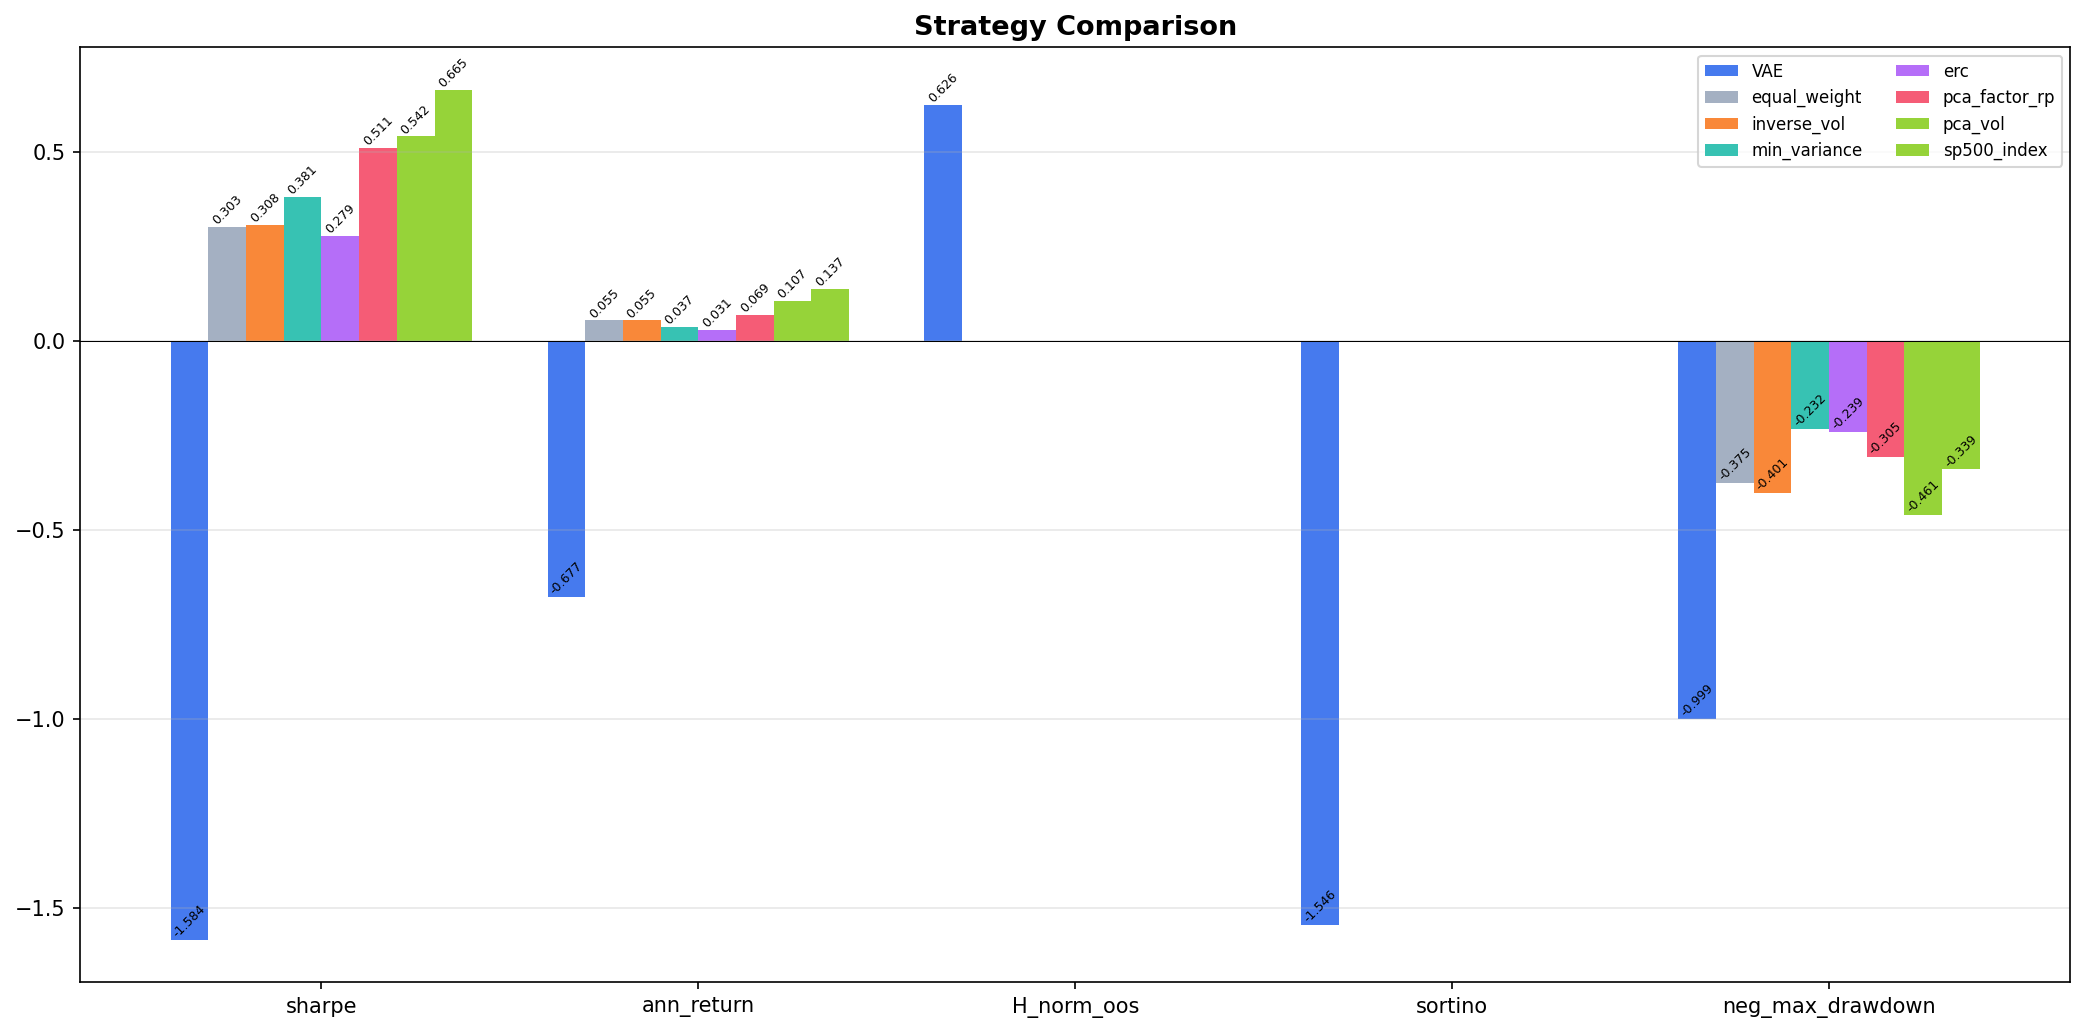

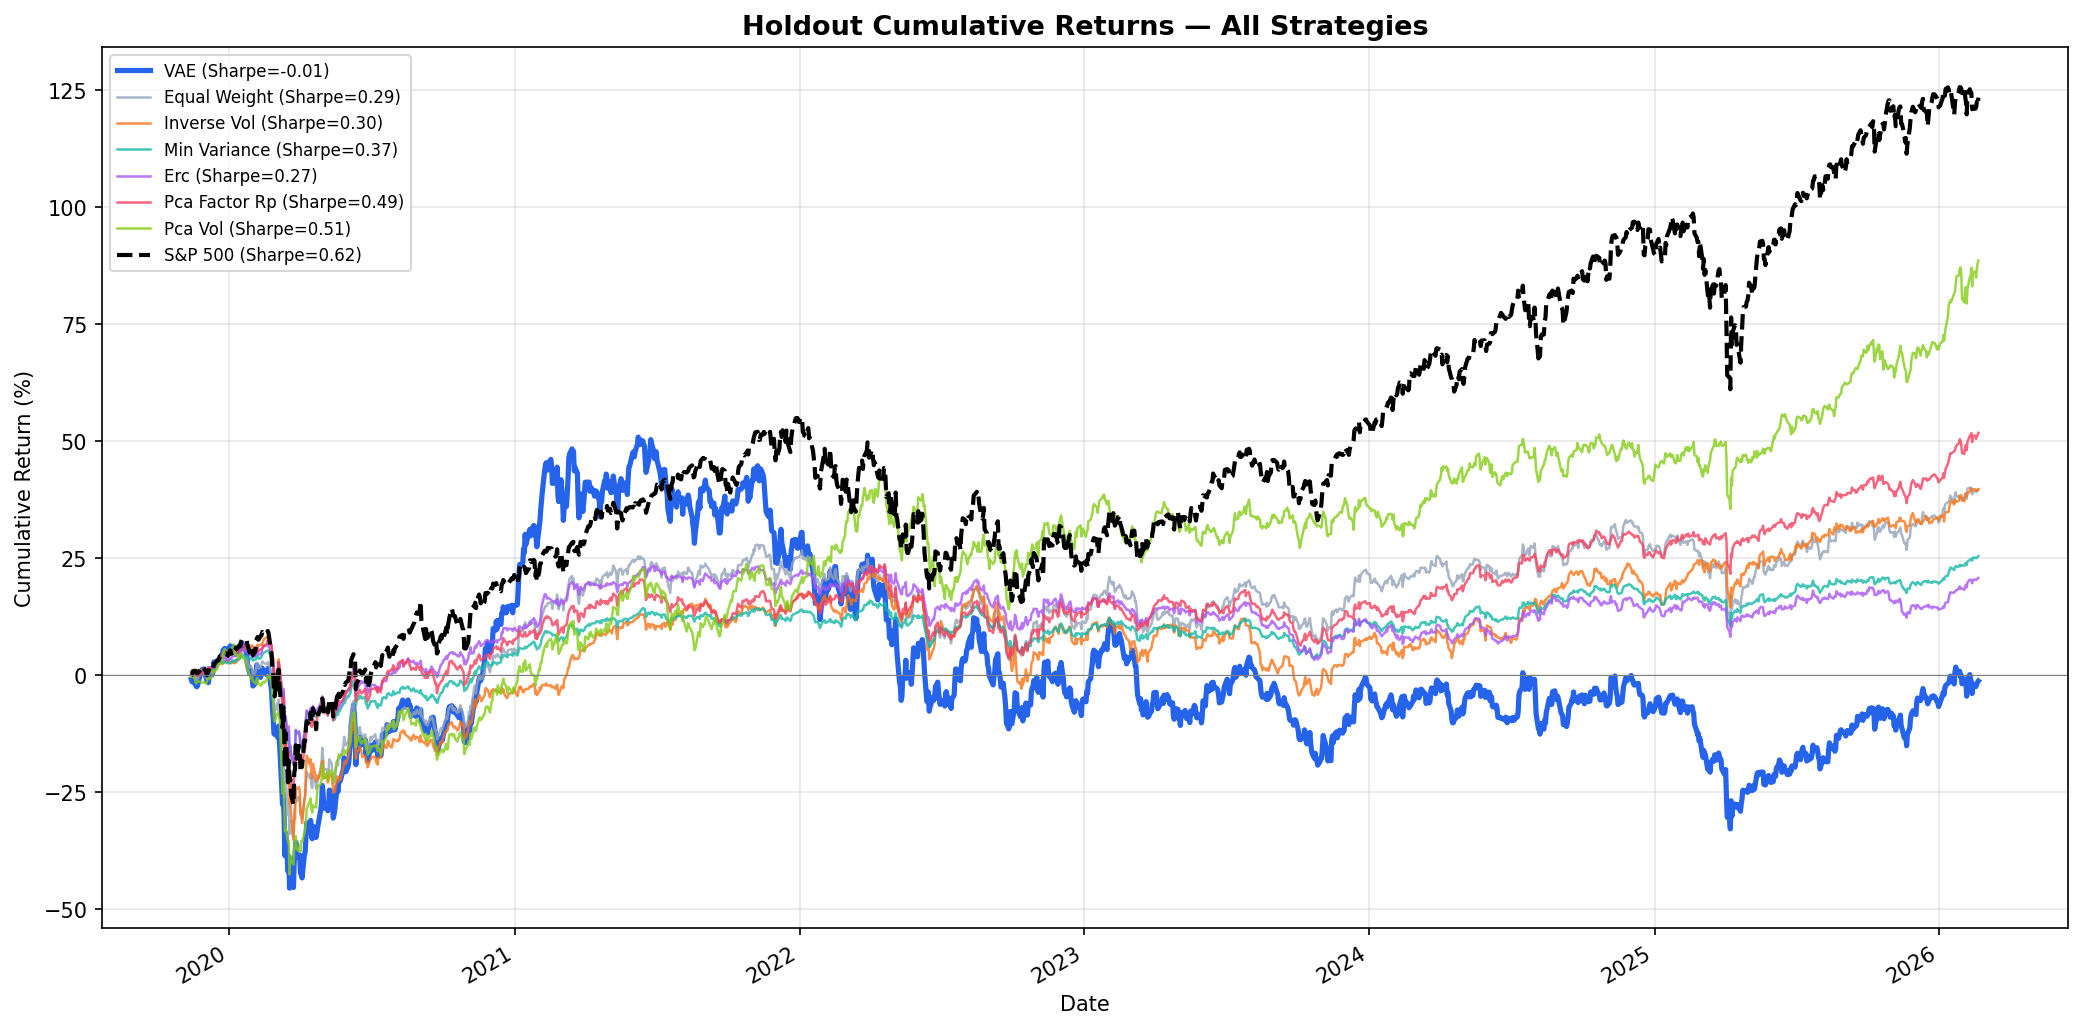

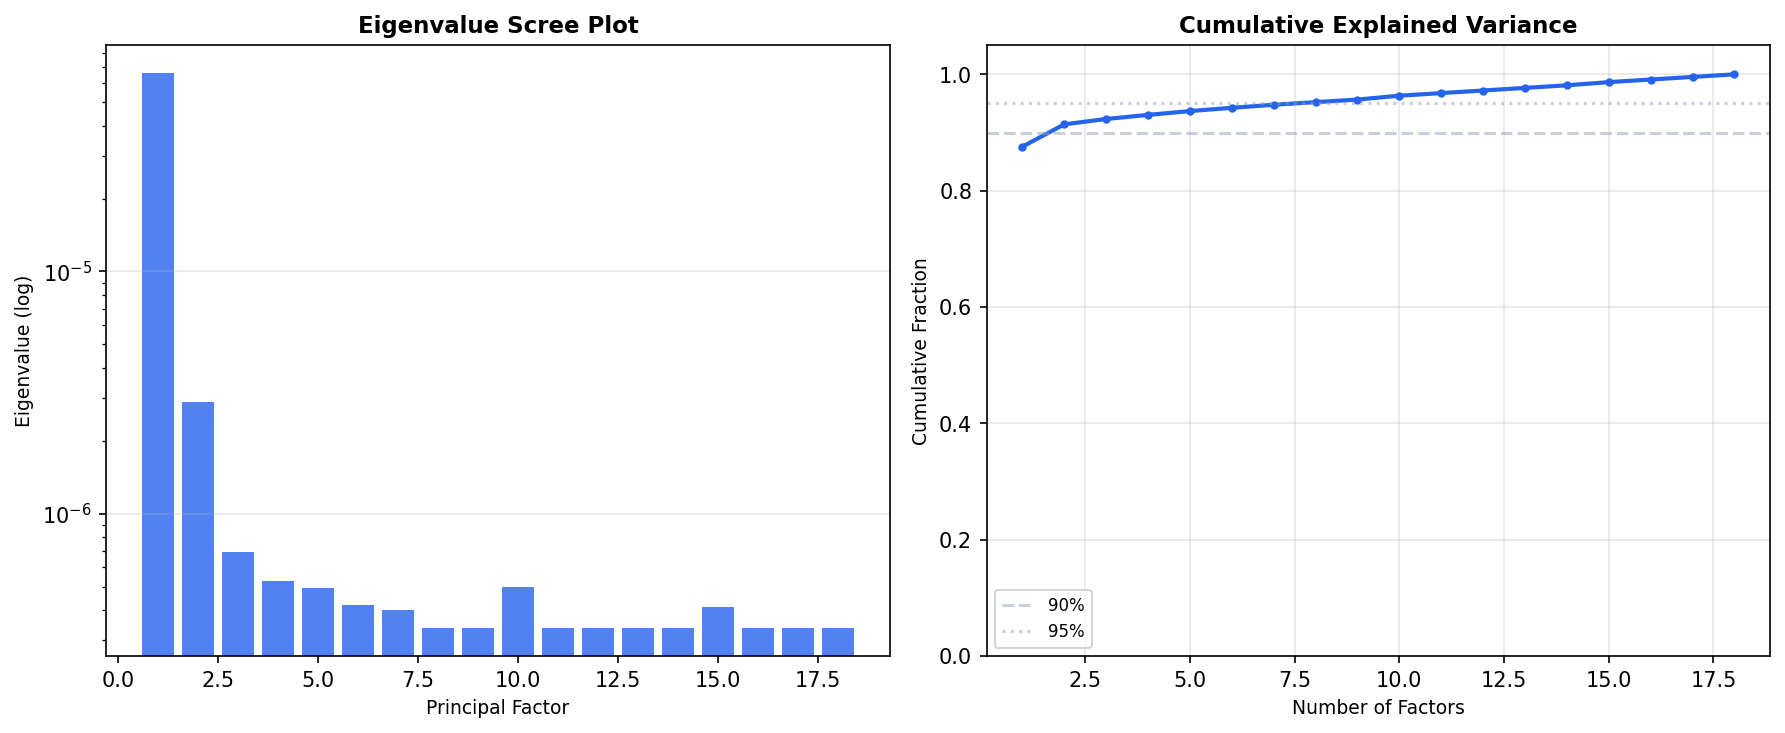

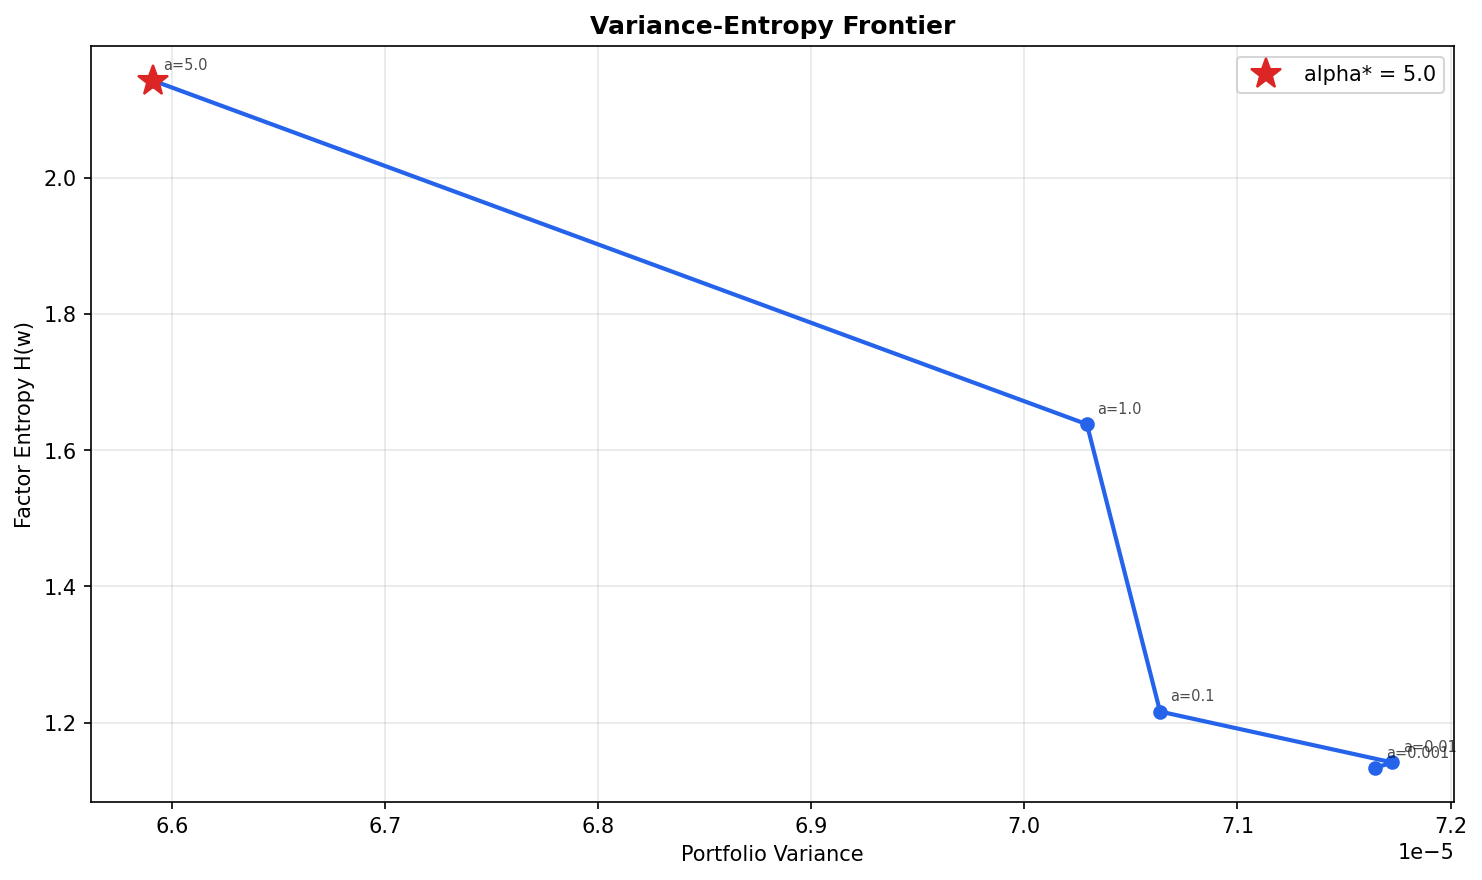

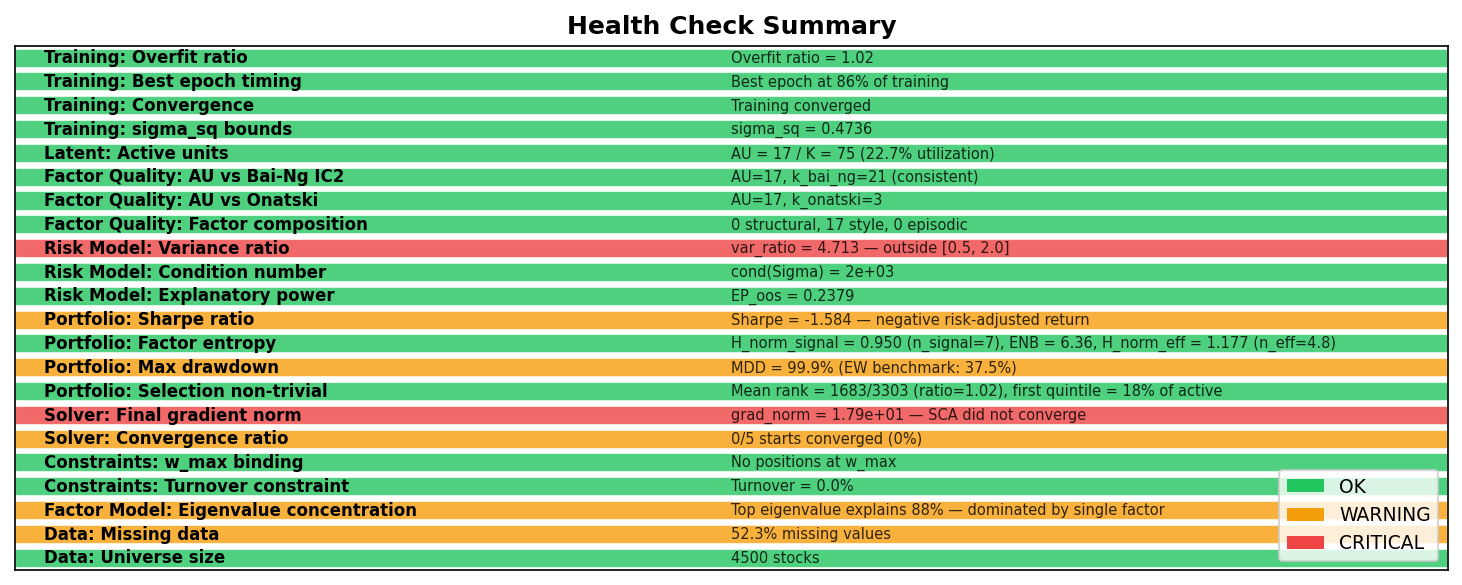

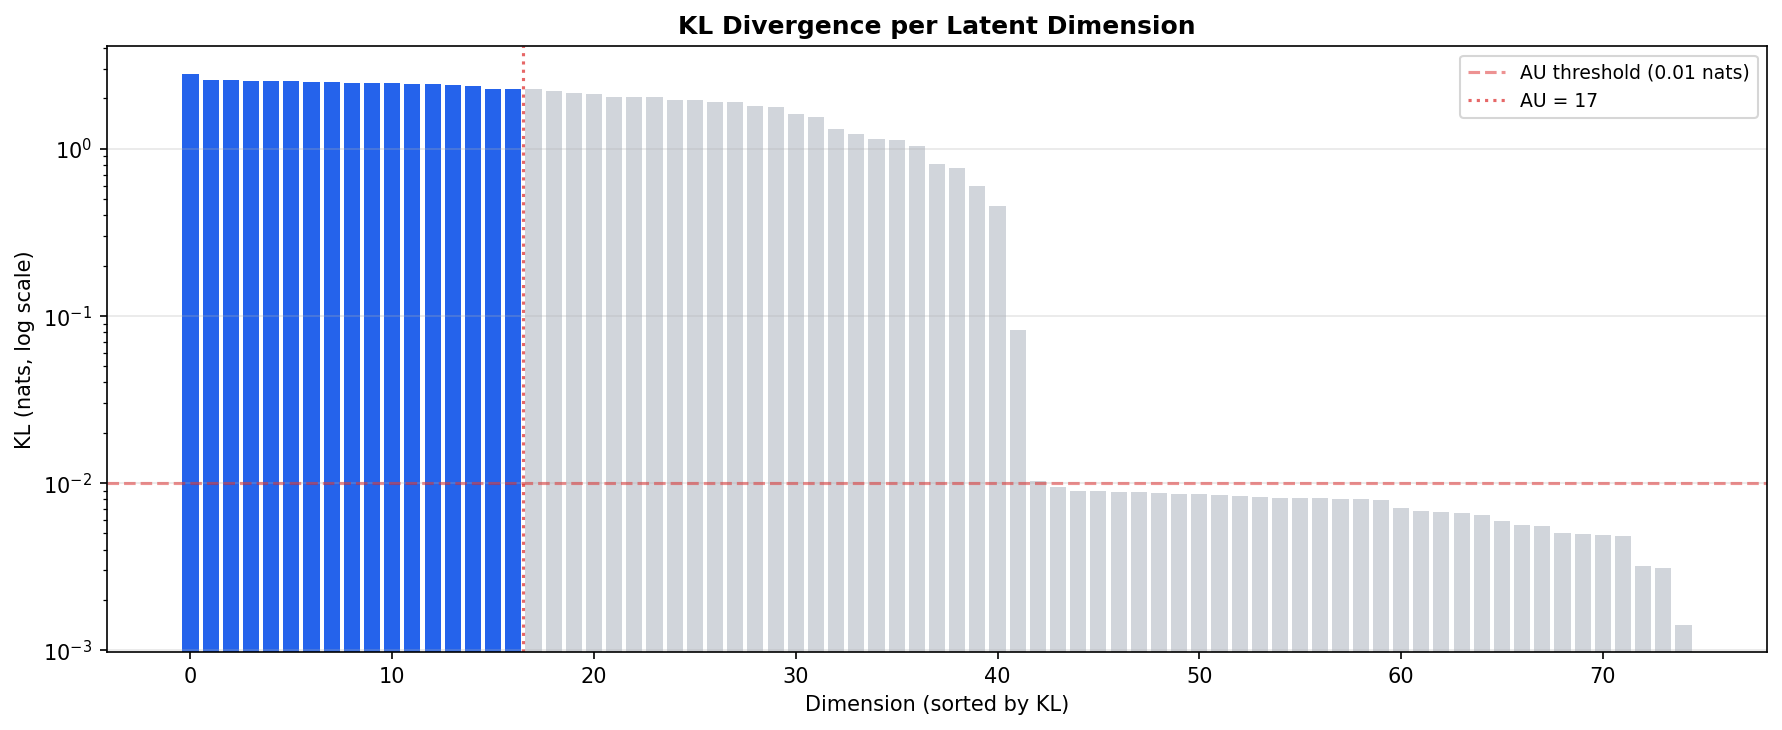

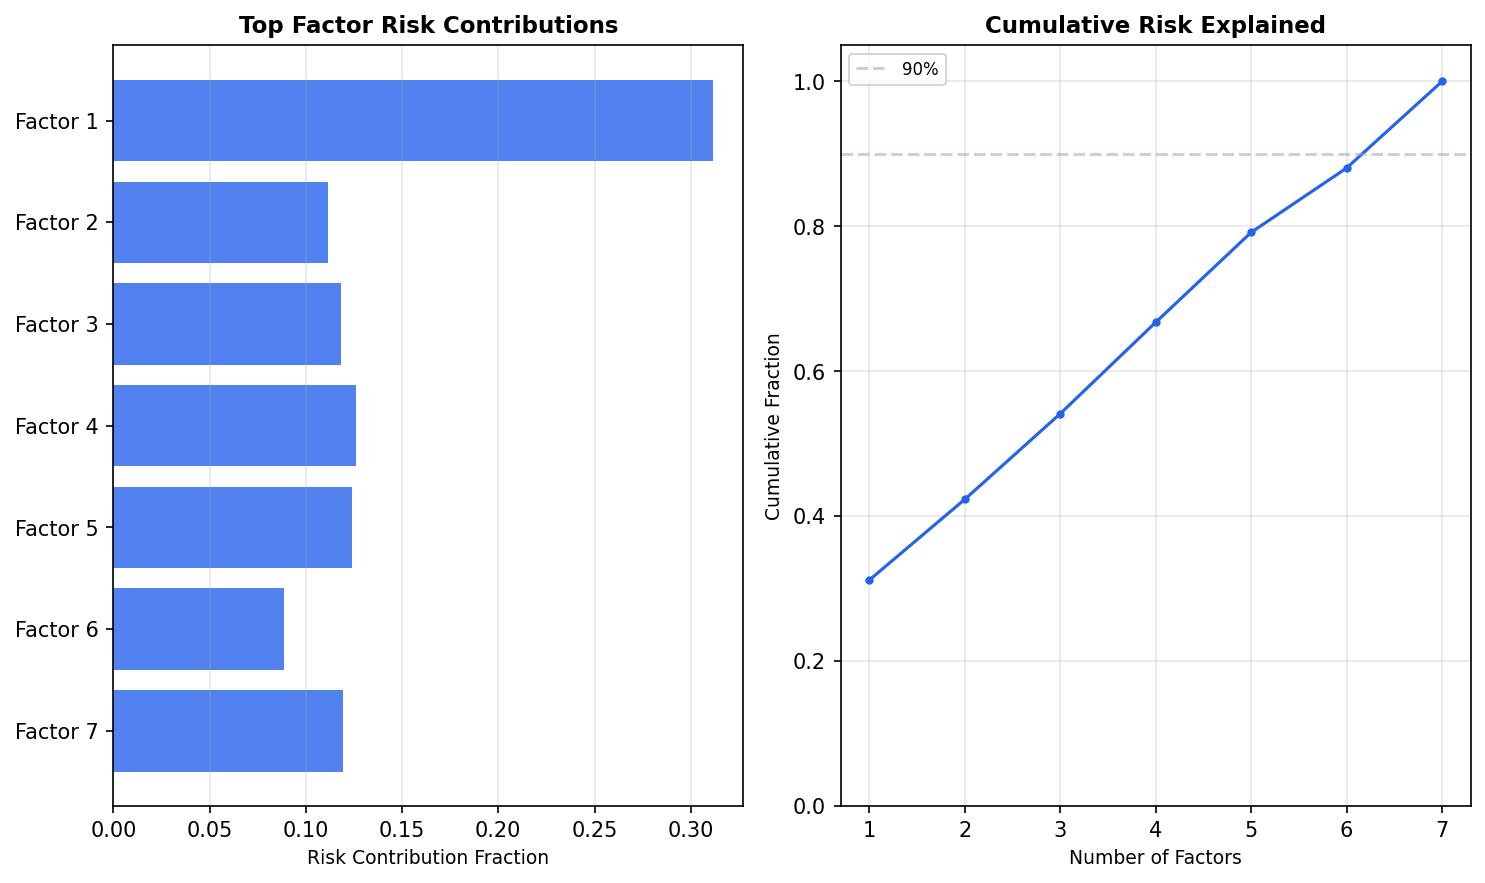

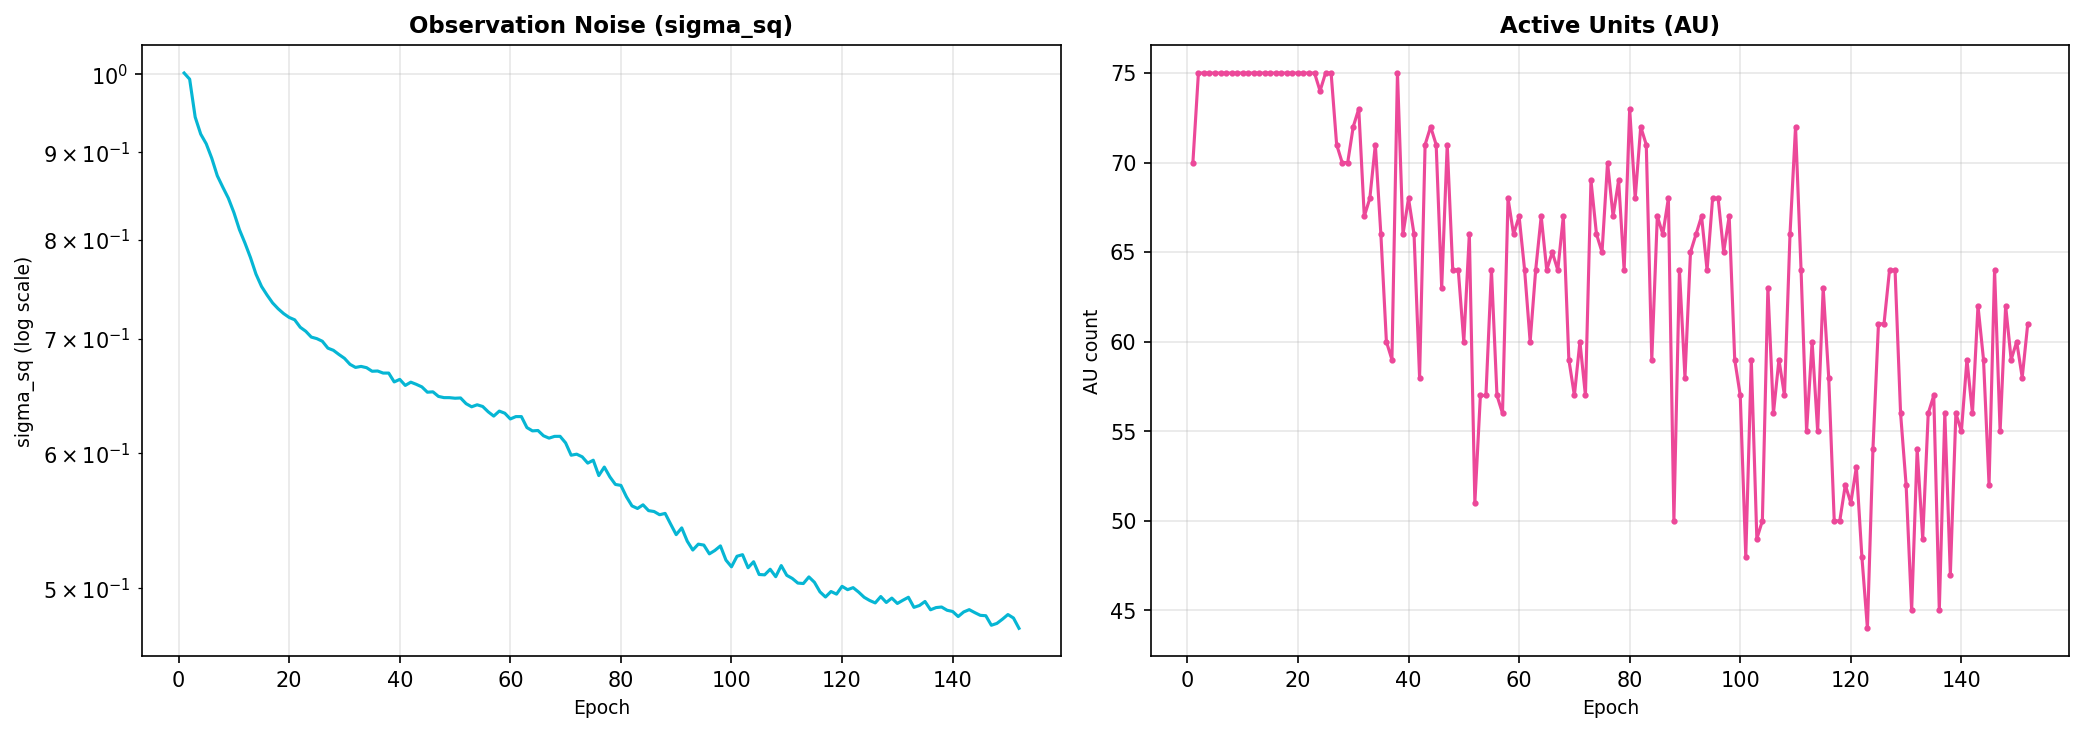

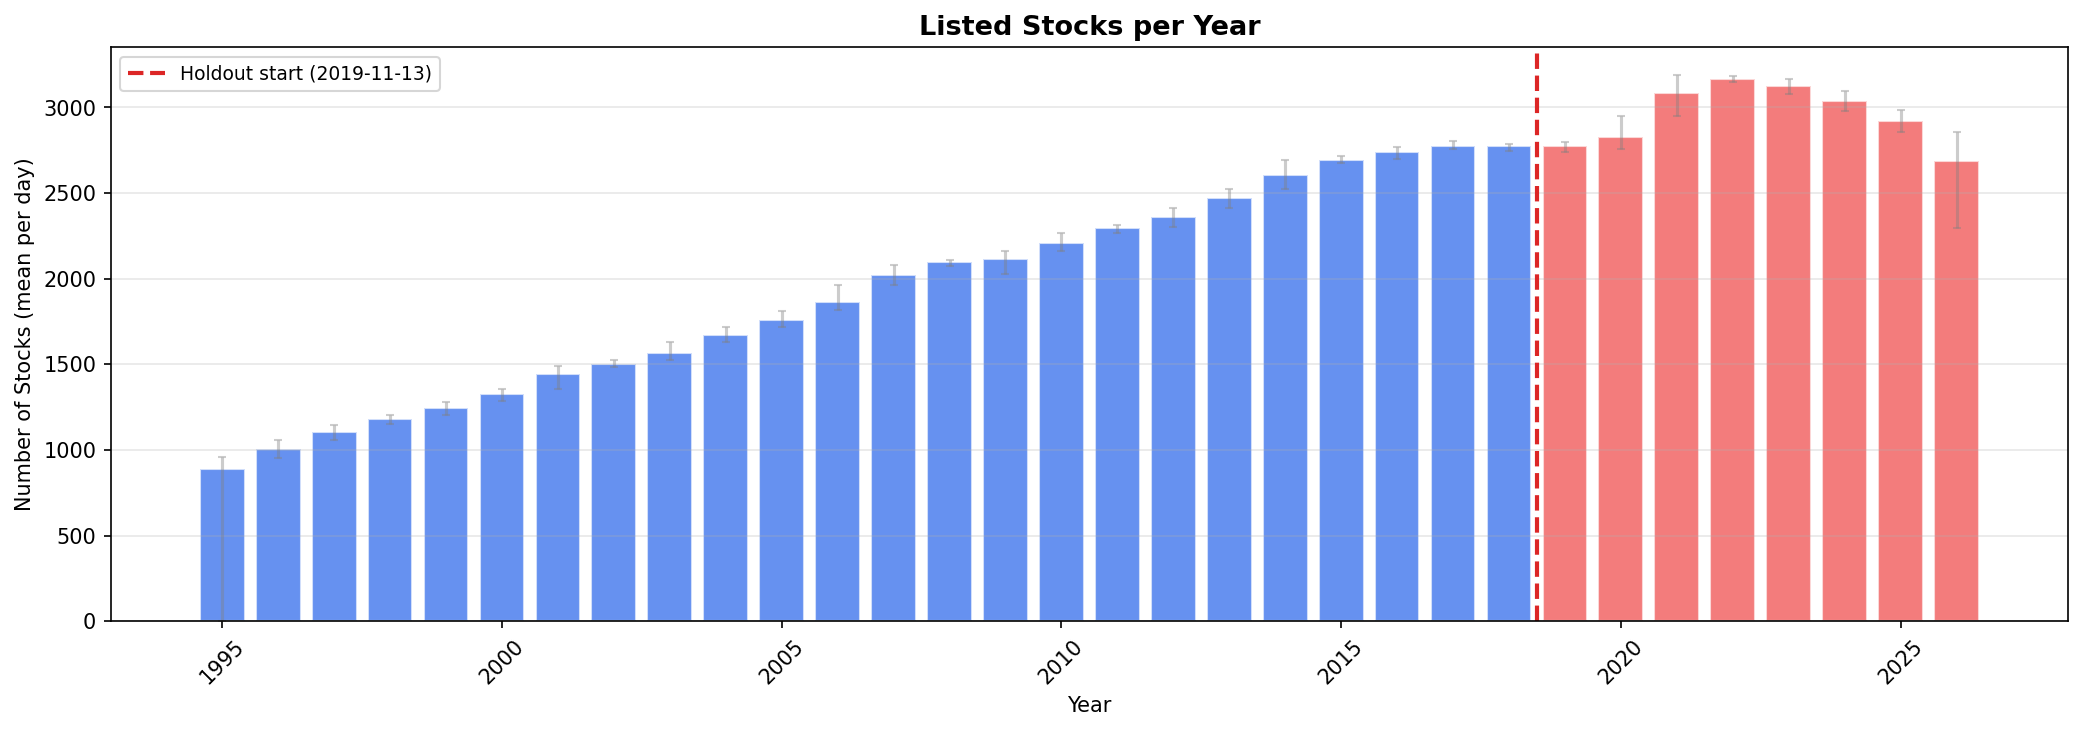

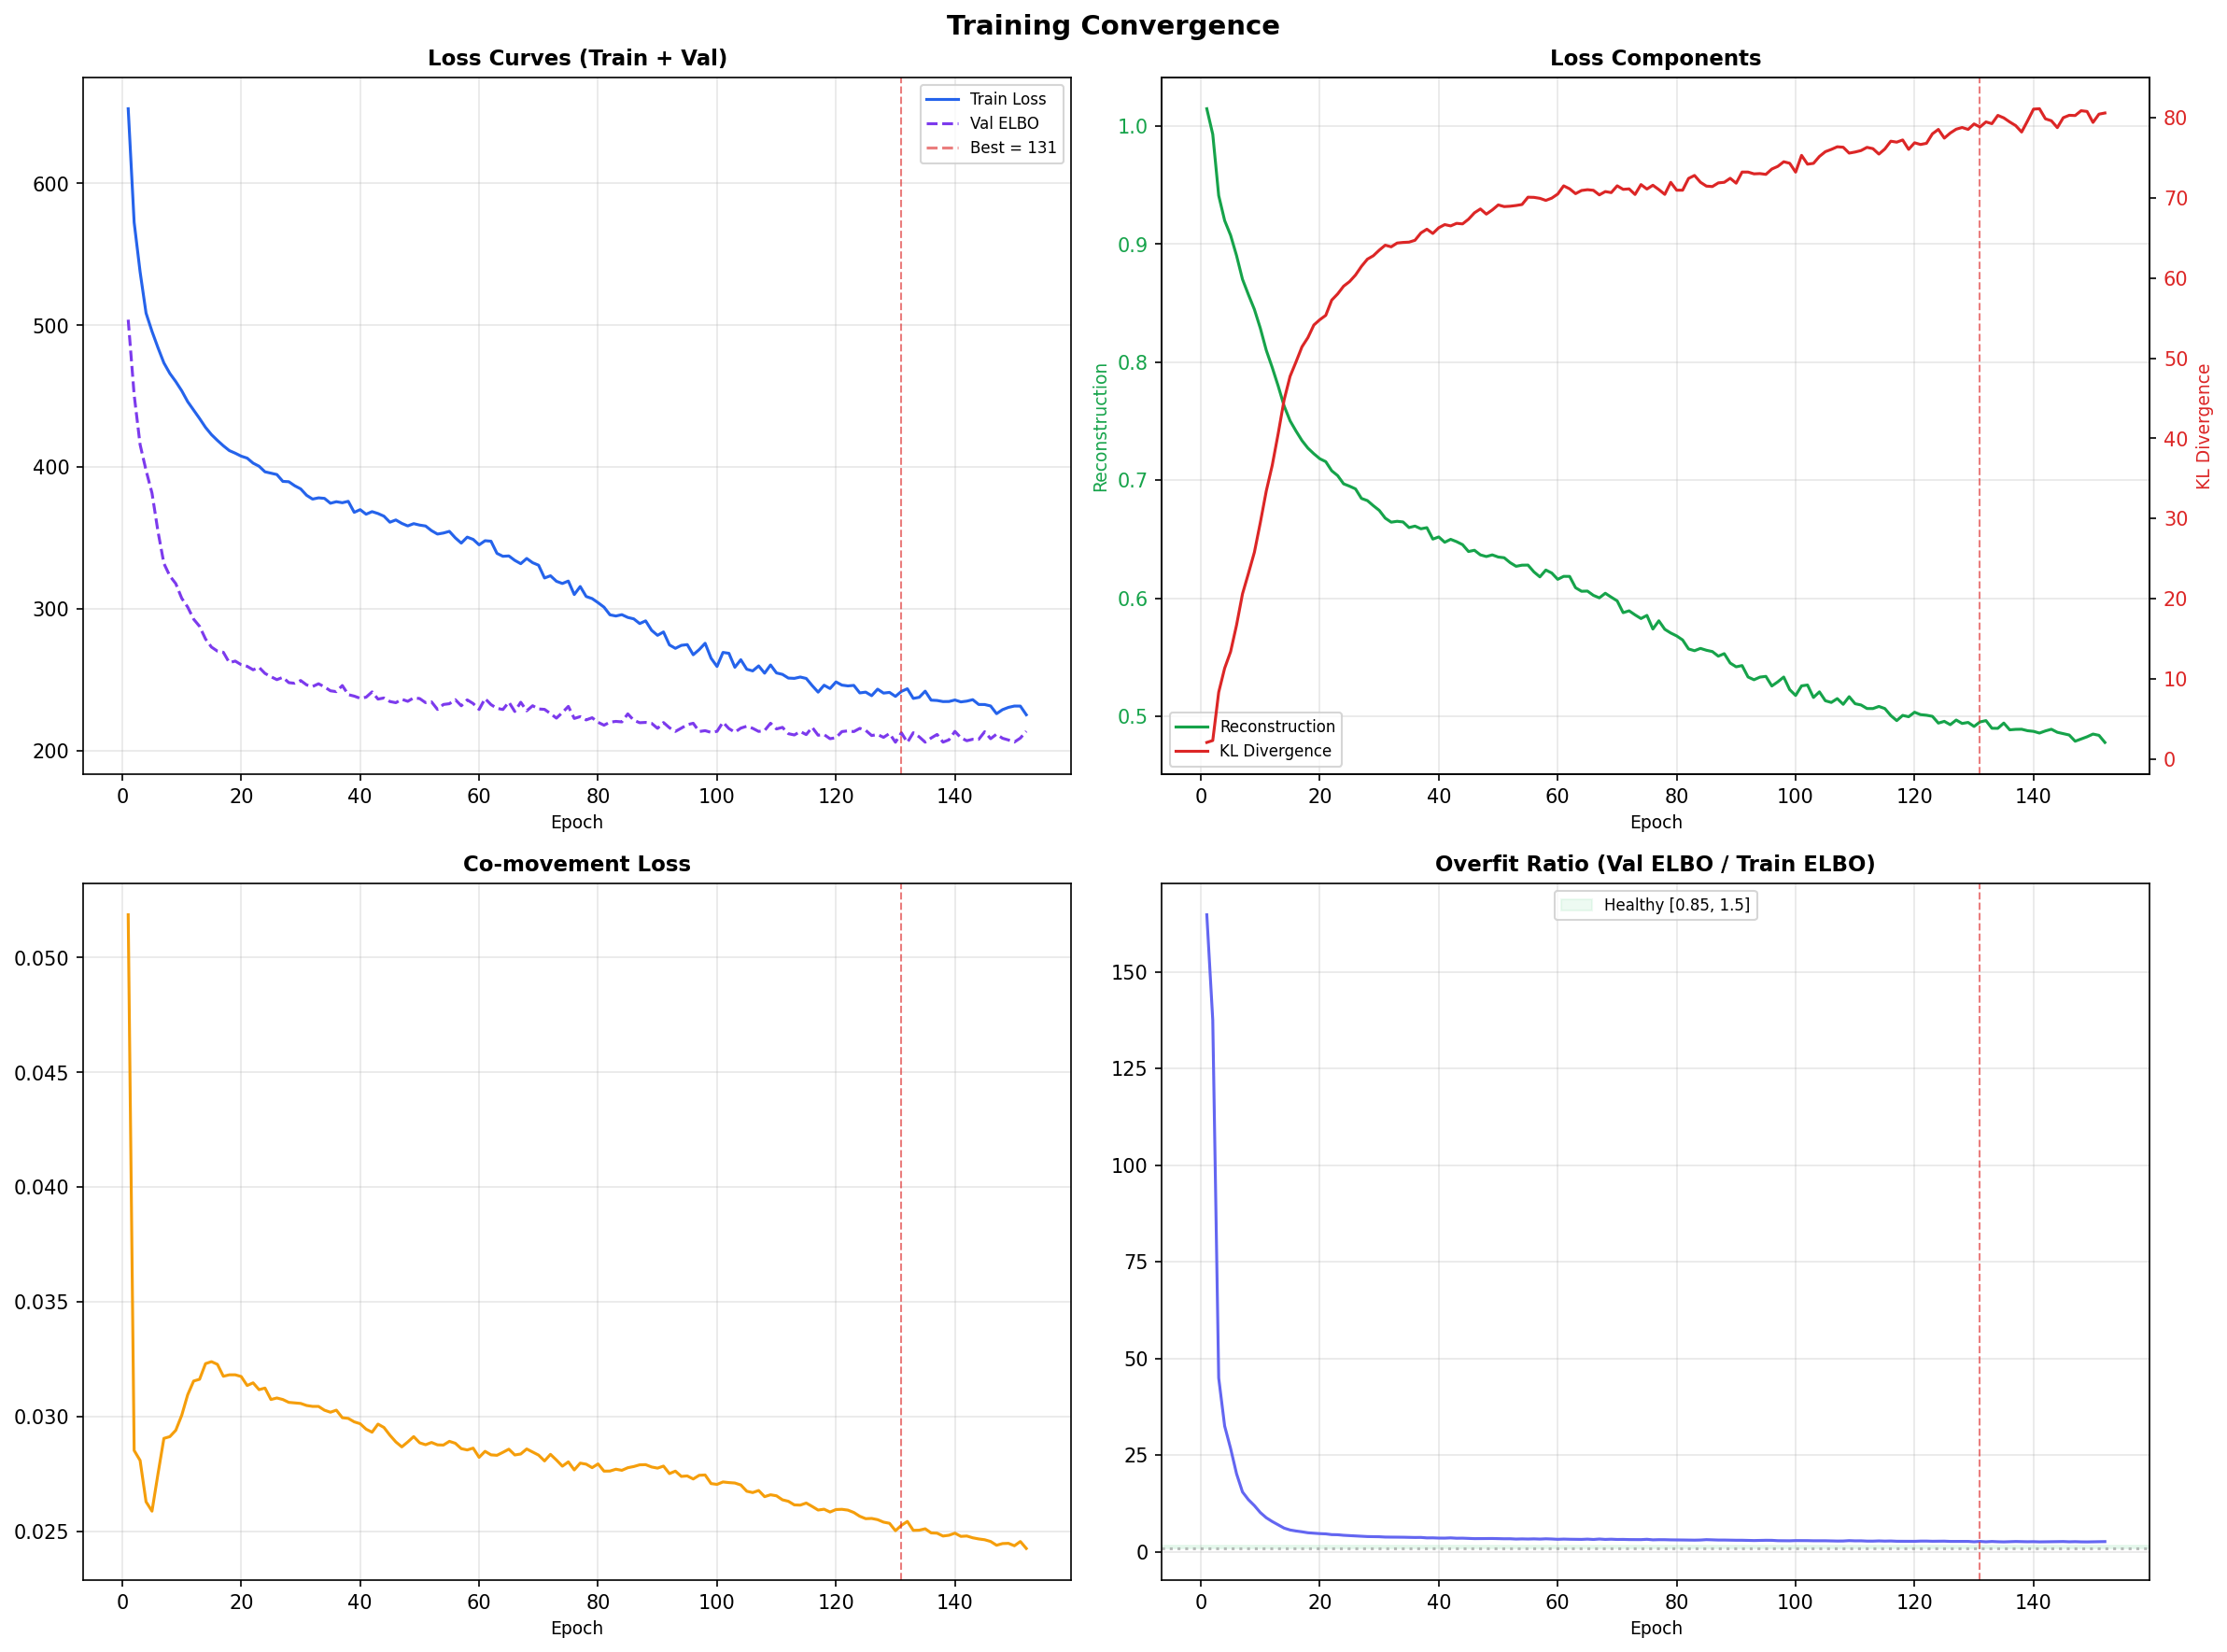

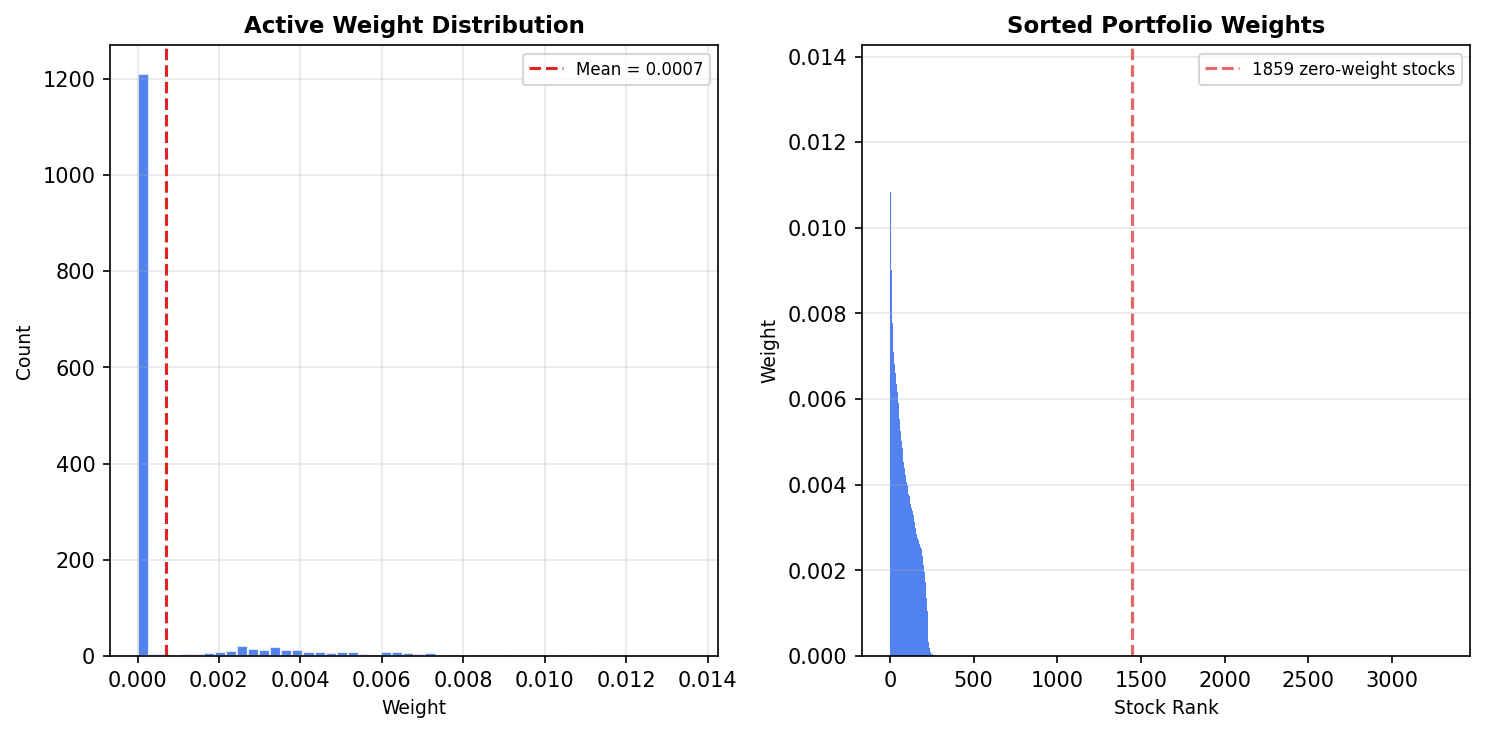

Report loaded from results/diagnostic_runs/2026-02-23_233353/diagnostic_report.md (13689 chars)



# VAE Latent Risk Factor — Diagnostic Report

---

## Executive Summary

**Overall Status: MARGINAL** (Score: 59/100, Grade: D)

Pipeline needs attention. Multiple components below threshold.

### Component Scores

| Component | Score | Grade | Status |
|-----------|-------|-------|--------|
| Solver | 5 | F | Critical |
| Constraints | 89 | B | Good |
| Covariance | 55 | D | Marginal |
| Reconstruction | 45 | D | Marginal |
| VAE Health | 72 | C | Review |
| Factor Model | 74 | C | Review |
| Training Convergence | 88 | B | Good |
| Active Units | 100 | A | Excellent |
| Portfolio Diversification | 74 | C | Review |
| Factor Stability | 55 | D | Marginal |

### Priority Actions

1. **Solver** (5): Increase sca_max_iter or reduce sca_tol
2. **Reconstruction** (45): Returns reconstruction very hard; check data preprocessing
3. **Factor_Stability** (55): Most factors are episodic — risk of OOS degradation
4. **Covariance** (55): Model underestimates risk; increase shrinkage or history

### Interpretation

- **Solver**: Optimization likely incomplete. Gradient norm = 1.79e+01, only 0% of starts converged.
- **Constraints**: Optimizer is free (interior solution). Only 0 positions at w_max (0%).
- **Covariance**: Calibration issues detected. var_ratio=4.71 (underestimates risk), EP=0.238, cond=1.8e+03.
- **Reconstruction**: Reconstruction issues. recon_loss=0.4952, feature_ratio=3.60 (returns much harder), overfit_ratio=1.02.
- **VAE Health**: VAE posterior acceptable. Collapse=0.0%, explosion=0.0%.
- **Factor Model**: Factor model acceptable. conc_ratio=0.88, R2=0.000±0.000.
- **Training**: Training converged optimally. Best epoch at 86%, 0 LR reductions.
- **Active Units**: Latent space well-utilized. AU=17/75 (23%), eff_dims=39.6.
- **Diversification**: Acceptable diversification. H_norm=0.950, ENB=6.4.
- **Stability**: Factor stability issues: few structural factors.

---

### Health Checks

| Status | Category | Check | Details |
|--------|----------|-------|---------|
| [OK] | Training | Overfit ratio | Overfit ratio = 1.02 |
| [OK] | Training | Best epoch timing | Best epoch at 86% of training |
| [OK] | Training | Convergence | Training converged |
| [OK] | Training | sigma_sq bounds | sigma_sq = 0.4736 |
| [OK] | Latent | Active units | AU = 17 / K = 75 (22.7% utilization) |
| [OK] | Factor Quality | AU vs Bai-Ng IC2 | AU=17, k_bai_ng=21 (consistent) |
| [OK] | Factor Quality | AU vs Onatski | AU=17, k_onatski=3 |
| [OK] | Factor Quality | Factor composition | 0 structural, 17 style, 0 episodic |
| [CRIT] | Risk Model | Variance ratio | var_ratio = 4.713 — outside [0.5, 2.0] |
| [OK] | Risk Model | Condition number | cond(Sigma) = 2e+03 |
| [OK] | Risk Model | Explanatory power | EP_oos = 0.2379 |
| [WARN] | Portfolio | Sharpe ratio | Sharpe = -1.584 — negative risk-adjusted return |
| [OK] | Portfolio | Factor entropy | H_norm_signal = 0.950 (n_signal=7), ENB = 6.36, H_norm_eff = 1.177 (n_eff=4.8) |
| [WARN] | Portfolio | Max drawdown | MDD = 99.9% (EW benchmark: 37.5%) |
| [OK] | Portfolio | Selection non-trivial | Mean rank = 1683/3303 (ratio=1.02), first quintile = 18% of active |
| [CRIT] | Solver | Final gradient norm | grad_norm = 1.79e+01 — SCA did not converge |
| [WARN] | Solver | Convergence ratio | 0/5 starts converged (0%) |
| [OK] | Constraints | w_max binding | No positions at w_max |
| [OK] | Constraints | Turnover constraint | Turnover = 0.0% |
| [WARN] | Factor Model | Eigenvalue concentration | Top eigenvalue explains 88% — dominated by single factor |
| [WARN] | Data | Missing data | 52.3% missing values |
| [OK] | Data | Universe size | 4500 stocks |

## 1. Data Quality

- **Universe size**: 4500 stocks
- **Date range**: 1995-01-03 to 2026-02-20
- **Trading days**: 7879
- **Years of data**: 31.3
- **Missing data**: 52.31%
- **Stocks > 20% missing**: 3426

## 2. Training Convergence

- **Epochs**: 152
- **Best epoch**: 131 (86% of total)
- **Best val ELBO**: 205.7974
- **Overfit flag**: False
- **Overfit ratio**: 1.0250
- **Val ELBO still decreasing at end**: False
- **LR reductions**: 0

### Loss Decomposition (best epoch)

| Component | Value |
|-----------|-------|
| Total loss | 241.7939 |
| Reconstruction | 0.4952 |
| KL divergence | 78.8404 |

### Observation Noise (sigma_sq)

- **Initial**: 1.0015
- **Final**: 0.4736
- **Hit lower bound**: False
- **Hit upper bound**: False

### Active Units Evolution

- **Initial**: 70
- **Final**: 61
- **Peak during training**: 75

### Per-Feature Reconstruction Loss (best epoch)

| Feature | MSE |
|---------|-----|
| Returns | 0.0126 |
| Volatility | 3.49e-03 |

*Returns/Volatility ratio: 3.60x — returns harder to reconstruct*


## 3. Latent Space Analysis

- **K (latent capacity)**: 75
- **AU (active units)**: 17
- **Utilization ratio**: 22.7%
- **Effective latent dims**: 39.6
- **KL total**: 80.3617
- **KL top-3 fraction**: 9.9%

### Exposure Matrix B

- **Shape**: [3303, 75]
- **Sparsity**: 0.0%
- **Max absolute entry**: 3.6742
- **Mean dim norm**: 8.4362
- **Mean stock norm**: 2.1622

## 3.5 Factor Quality Dashboard

### AU Validation

- **VAE Active Units (AU)**: 17
- **Bai-Ng IC2 optimal k**: 21
- **Onatski test k**: 3

**Status**: [OK] AU consistent with statistical tests

### Factor Composition

- **Structural factors**: 0 (0%)
- **Style factors**: 17
- **Episodic factors**: 0

### Top Factors (by KL divergence)

| Factor | Breadth | Persistence (days) | Category |
|--------|---------|-------------------|----------|
| 1 | 0 | inf | Style |
| 2 | 0 | inf | Style |
| 3 | 0 | inf | Style |
| 4 | 0 | inf | Style |
| 5 | 0 | inf | Style |
| 6 | 0 | inf | Style |
| 7 | 0 | inf | Style |
| 8 | 0 | inf | Style |
| 9 | 0 | inf | Style |
| 10 | 0 | inf | Style |

### Latent Stability

- **Spearman rho between folds**: N/A (single fold or first fold)

## 4. Risk Model Quality

- **Variance targeting**: sys=0.5000, idio=0.5147
- **Variance ratio (OOS)**: 4.7132 (target: [0.5, 2.0])
- **Rank correlation (OOS)**: 0.3262
- **Explanatory power (OOS)**: 0.2379
- **Avg cross-sectional R² (OOS)**: 0.0267

### Exposure Matrix (B_A) Scale

- **Mean |B_A|**: 0.6510
- **Std B_A**: 0.8741
- **Max |B_A|**: 3.5000
- **Column norm (mean)**: 50.1221
- **Column norm (max)**: 57.4515
- **Condition number**: 1.84e+03

### Eigenvalue Spectrum

- **Number of eigenvalues**: 18
- **Top eigenvalue**: 6.60e-05
- **Top 3 explained**: 92.3%
- **Top 10 explained**: 96.3%
- **Ratio #1/#2**: 22.78

## 5. Portfolio Optimization

- **Alpha (risk aversion)**: 5.0000
- **Active positions**: 1444 / 3303
- **Effective N**: 181.8
- **HHI**: 5.50e-03
- **Gini coefficient**: 0.8826
- **Max weight**: 0.0136
- **Min active weight**: 1.64e-06

### Factor Risk Decomposition

- **Top 1 factor contribution**: 31.2%
- **Top 3 factor contribution**: 54.1%
- **Risk entropy (H)**: 1.8493
- **Max possible entropy**: 1.9459

### Solver Convergence (SCA)

- **Multi-start runs**: 5
- **Converged runs**: 0 (0%)
- **Best start index**: 3
- **Best converged**: False
- **Best final gradient norm**: 1.79e+01
- **Best iterations**: 300
- **Average iterations**: 300.0
- **Max iterations**: 300

### Constraint Binding Status

- **Positions at w_max**: 0
- **Positions at w_min**: 0
- **Positions above w_bar**: 49
- **Binding fraction**: 0.0%
- **w_max constraint binding**: False
- **Turnover constraint binding**: False
- **Actual turnover**: 0.0%
- **Concentrated weight (>w_bar)**: 23.6%

## 6. Out-of-Sample Performance

### VAE Portfolio

- **Annualized return**: -67.72%
- **Annualized volatility**: 42.75%
- **Sharpe ratio**: -1.584
- **Sortino ratio**: -1.546
- **Calmar ratio**: -0.678
- **Max drawdown**: 99.92% (EW benchmark: 37.47%)
- **Normalized entropy (H_norm)**: 0.6260
- **H_norm_signal (vs n_signal)**: 0.9504 (n_signal = 7, ENB = 6.36)
- **H_norm_eff (vs effective dims)**: 1.1766 (n_eff = 4.8)

### VAE vs Benchmarks

| Metric | VAE | Equal Weight | Inverse Vol | Min Variance | Erc | Pca Factor Rp | Pca Vol | Sp500 Index |
|--------|-----|------|------|------|------|------|------|------|
| sharpe | -1.5841 | 0.3029 | 0.3082 | 0.3809 | 0.2785 | 0.5110 | 0.5419 | 0.6653 |
| ann_return | -0.6772 | 0.0550 | 0.0550 | 0.0370 | 0.0307 | 0.0691 | 0.1068 | 0.1372 |
| ann_vol_oos | 0.4275 | 0.1816 | 0.1784 | 0.0971 | 0.1103 | 0.1351 | 0.1972 | 0.2062 |
| max_drawdown_oos | 0.9992 | 0.3747 | 0.4008 | 0.2322 | 0.2393 | 0.3052 | 0.4608 | 0.3392 |
| H_norm_oos | 0.6260 | nan | nan | nan | nan | nan | nan | nan |
| eff_n_positions | 181.8242 | 1831.0000 | 35.8696 | 45.0903 | 49.8464 | 142.0749 | 78.6884 | 500.0000 |

### Win/Loss Summary

| Benchmark | VAE Wins | VAE Losses |
|-----------|----------|------------|
| equal_weight | 0 | 6 |
| inverse_vol | 1 | 5 |
| min_variance | 1 | 5 |
| erc | 1 | 5 |
| pca_factor_rp | 1 | 5 |
| pca_vol | 1 | 5 |
| sp500_index | 0 | 6 |

**Total: 5 wins, 37 losses**

## 7. Diagnosis & Recommendations

- **Covariance underestimation** (var_ratio = 4.713): the model predicts less risk than observed. The risk model may be poorly calibrated.
- **VAE underperforms benchmarks with negative Sharpe**: the strategy is not adding value. Consider fundamental changes to the approach (loss mode, K, training period).
- **SCA solver did not converge** (grad_norm = 1.79e+01): the portfolio optimization may be stuck at a suboptimal point. Consider increasing max_iter, adjusting step_size, or checking if the objective landscape is ill-conditioned.
- **Low multi-start convergence** (0%): many optimization restarts did not converge. The objective may have many local optima or poor conditioning.

## Appendix: Configuration

```json
{
  "data": {
    "n_stocks": 4500,
    "window_length": 504,
    "n_features": 2,
    "vol_window": 252,
    "vix_lookback_percentile": 80.0,
    "min_valid_fraction": 0.8,
    "data_source": "synthetic",
    "data_dir": "data/",
    "training_stride": 21
  },
  "vae": {
    "K": 75,
    "sigma_sq_init": 1.0,
    "sigma_sq_min": 0.0001,
    "sigma_sq_max": 10.0,
    "window_length": 504,
    "n_features": 2,
    "r_max": 5.0,
    "dropout": 0.2
  },
  "loss": {
    "mode": "P",
    "gamma": 3.0,
    "lambda_co_max": 0.5,
    "beta_fixed": 1.0,
    "warmup_fraction": 0.2,
    "max_pairs": 2048,
    "delta_sync": 21,
    "lambda_cs": 0.5,
    "cs_n_sample_dates": 20,
    "feature_weights": [
      2.0,
      0.5
    ]
  },
  "training": {
    "max_epochs": 500,
    "batch_size": 512,
    "learning_rate": 0.005,
    "weight_decay": 1e-05,
    "adam_betas": [
      0.9,
      0.999
    ],
    "adam_eps": 1e-08,
    "patience": 20,
    "es_min_delta": 0.0,
    "lr_patience": 30,
    "lr_factor": 0.75,
    "n_strata": 15,
    "curriculum_phase1_frac": 0.4,
    "curriculum_phase2_frac": 0.3,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": false,
    "compile_model": true
  },
  "inference": {
    "batch_size": 512,
    "au_threshold": 0.01,
    "r_min": 2,
    "aggregation_method": "mean",
    "aggregation_half_life": 60
  },
  "risk_model": {
    "winsorize_lo": 5.0,
    "winsorize_hi": 95.0,
    "d_eps_floor": 1e-06,
    "conditioning_threshold": 1000000.0,
    "ridge_scale": 1e-06,
    "sigma_z_shrinkage": "analytical_nonlinear",
    "sigma_z_eigenvalue_pct": 0.95,
    "sigma_z_ewma_half_life": 0,
    "au_max_bai_ng_factor": 1.0,
    "b_a_shrinkage_alpha": 0.0,
    "b_a_clip_threshold": 3.5,
    "use_wls": true,
    "b_a_normalize": true,
    "market_intercept": true,
    "vt_clamp_min": 0.5,
    "vt_clamp_max": 2.0
  },
  "portfolio": {
    "lambda_risk": 252.0,
    "w_max": 0.03,
    "w_min": 0.001,
    "w_bar": 0.015,
    "phi": 15.0,
    "kappa_1": 0.1,
    "kappa_2": 7.5,
    "delta_bar": 0.01,
    "tau_max": 0.3,
    "n_starts": 5,
    "sca_max_iter": 300,
    "sca_tol": 1e-08,
    "armijo_c": 0.0001,
    "armijo_rho": 0.5,
    "armijo_max_iter": 20,
    "max_cardinality_elim": 100,
    "entropy_eps": 1e-30,
    "cardinality_method": "auto",
    "alpha_grid": [
      0,
      0.001,
      0.005,
      0.01,
      0.02,
      0.05,
      0.1,
      0.2,
      0.5,
      1.0,
      2.0,
      5.0
    ],
    "momentum_enabled": true,
    "momentum_lookback": 252,
    "momentum_skip": 21,
    "momentum_weight": 0.3,
    "entropy_idio_weight": 0.2,
    "target_enb": 0.0,
    "transaction_cost_bps": 10.0,
    "normalize_entropy_gradient": true,
    "entropy_budget_mode": "proportional",
    "rebalancing_frequency_days": 63,
    "entropy_trigger_alpha": 0.9,
    "delisting_return_nyse_amex": -0.3,
    "delisting_return_nasdaq": -0.55,
    "oos_n_starts_scheduled": 2,
    "oos_n_starts_exceptional": 5,
    "oos_sca_max_iter_scheduled": 50,
    "oos_sca_max_iter_exceptional": 100,
    "frontier_coarse_grid": [
      0.001,
      0.01,
      0.1,
      1.0,
      5.0
    ],
    "frontier_early_stop_patience": 2,
    "frontier_n_starts_after_target": 2,
    "frontier_max_iter_after_target": 50,
    "frontier_refine_enabled": true,
    "frontier_refine_points": 3,
    "frontier_n_starts_refine": 3,
    "frontier_max_iter_refine": 75,
    "use_fast_subproblem": true,
    "fast_subproblem_max_iter": 50,
    "fast_subproblem_tol": 1e-07
  },
  "walk_forward": {
    "total_years": 40,
    "min_training_years": 10,
    "oos_months": 6,
    "embargo_days": 21,
    "holdout_years": 3,
    "val_years": 2,
    "score_lambda_pen": 5.0,
    "score_lambda_est": 2.0,
    "score_mdd_threshold": 0.2
  },
  "seed": 42,
  "_diagnostic": {
    "profile": "full",
    "data_source": "tiingo",
    "n_stocks_actual": 4500,
    "n_dates_actual": 7879,
    "date_range": "1995-01-03 to 2026-02-20",
    "pipeline_time_seconds": 20072.522552155,
    "holdout_fraction": 0.2,
    "loss_mode": "P"
  }
}
```


Portfolio Holdings: 1444 active positions
  Total weight: 99.8%
  Weight range: 0.00% – 1.36%



,Ticker,Weight (%),Market Cap ($M),Exchange,S&P 500,Permno
1,BAND,1.36,NaN,NASDAQ,,12050
2,PUMP,1.26,612.0,NYSE,,25702
3,SEI,1.13,2752.0,NYSE,,27144
4,NEXA,1.12,155.0,NYSE,,23332
5,NGVT,1.08,447.0,NYSE,,23402
...,...,...,...,...,...,...
1440,FCPT,0.00,459.0,NYSE,,17016
1441,FCNCA,0.00,3876.0,NASDAQ,,17009
1442,FCN,0.00,935.0,NYSE,,17007
1443,FCFS,0.00,940.0,NASDAQ,,16996


AttributeError: 'list' object has no attribute 'shape'

In [44]:
# ============================================================
# 9b-9e. CONSOLIDATED DIAGNOSTIC DISPLAY
# ============================================================
# Displays: plots, report, holdings, exposures, ML diagnostics, ZIP export
from src.integration.notebook_helpers import display_diagnostic_results

summary = display_diagnostic_results(
    diagnostics=diagnostics,
    run_data=run_data,
    output_dir=ACTIVE_RUN_DIR,
    data_dir=DATA_DIR,
    stock_data=stock_data if 'stock_data' in dir() else None,
)
print(f"\nDisplay Summary: {summary}")

In [ ]:
# ============================================================
# 9f. OOS REPLAY FROM CHECKPOINT
# ============================================================
# Re-runs ONLY the OOS simulation using saved checkpoint data.
# Skips: VAE training (~5h), portfolio optimization (~5min), benchmarks (~10min).
# Reconstructs risk model from B_A + data (~30s), then runs OOS (~5-10min).
#
# Set REPLAY_OOS = True to run. Requires data from Section 2 (returns,
# trailing_vol, stock_data) and a completed run in RUN_DIR (Section 9a).
# ============================================================
from importlib import reload
import src.walk_forward.oos_rebalancing as _oos; reload(_oos)
import src.integration.notebook_helpers as _nh; reload(_nh)
from src.integration.notebook_helpers import replay_oos_simulation

REPLAY_OOS = True
REPLAY_REFRESH_RISK_MODEL = True  # Enable risk model refresh during OOS

if REPLAY_OOS and RUN_DIR:
    replay_result = replay_oos_simulation(
        run_dir=RUN_DIR,
        returns=returns,
        trailing_vol=trailing_vol,
        config=config,
        stock_data=stock_data if 'stock_data' in dir() else None,
        holdout_fraction=DIAG_HOLDOUT_FRACTION,
        holdout_start=DIAG_HOLDOUT_START,
        refresh_risk_model=REPLAY_REFRESH_RISK_MODEL,
    )

    # Display results
    m = replay_result["metrics"]
    d = replay_result["dates"]
    oos = replay_result["oos_result"]
    print(f"\n{'='*60}")
    print(f"OOS REPLAY RESULTS  (refresh={REPLAY_REFRESH_RISK_MODEL})")
    print(f"{'='*60}")
    print(f"  Period:       [{d['oos_start']}] to [{d['oos_end']}]")
    print(f"  Sharpe (net): {m.get('sharpe', 0):.3f}")
    print(f"  Ann. return:  {m.get('ann_return', 0):.2%}")
    print(f"  Ann. vol:     {m.get('ann_vol_oos', 0):.2%}")
    print(f"  Max drawdown: {m.get('max_drawdown_oos', 0):.2%}")
    print(f"  Sortino:      {m.get('sortino', 0):.3f}")
    print(f"  Calmar:       {m.get('calmar', 0):.3f}")
    print(f"  Rebalances:   {oos.n_scheduled_rebalances} scheduled, "
          f"{oos.n_exceptional_rebalances} exceptional")
    print(f"  Turnover:     {oos.cumulative_turnover*100:.1f}%")
    print(f"  TC:           {oos.total_transaction_cost*100:.2f}%")
    print(f"  Total time:   {replay_result['total_time_sec']:.1f}s")
else:
    print("OOS Replay skipped (set REPLAY_OOS=True and RUN_DIR to run)")


2026-02-24 11:34:34,624 [INFO] src.integration.notebook_helpers: Loading checkpoint from results/diagnostic_runs/2026-02-23_233353...
2026-02-24 11:34:34,633 [INFO] src.integration.notebook_helpers:   Checkpoint loaded: w_vae(3303), B_A((3303, 17)), 3303 stocks, alpha=5.00
2026-02-24 11:34:34,635 [INFO] src.integration.notebook_helpers:   Split: train [1995-01-03, 2019-11-12] (6303 days), OOS [2019-11-13, 2026-02-20] (1576 days)
2026-02-24 11:34:34,635 [INFO] src.integration.notebook_helpers:   Reconstructing risk model from B_A...
2026-02-24 11:34:55,055 [INFO] src.risk_model.rescaling: Estimation rescaling: 6051/6303 dates processed, 252 skipped (no_stocks=0, no_vol_date=0, insufficient_vol=252)
2026-02-24 11:35:08,517 [INFO] src.integration.notebook_helpers:   Factor regression: 6051 valid dates, 18 factors
2026-02-24 11:35:11,833 [WARNING] src.risk_model.covariance:   covShrinkage not installed, falling back to spiked shrinkage. Install with: pip install covShrinkage
2026-02-24 11:

---
## 10. Decision Synthesis

This section provides an automated root cause analysis and actionable recommendations
based on the diagnostic scores from Section 9. It helps identify the underlying causes
of any issues and suggests specific configuration changes.

**Components:**
- Root Cause Analysis with matched decision rules
- Causal chain visualization
- Executable configuration recommendations
- Validated JSON output for automation

**Source modules:**
- `src/integration/decision_rules.py` — 10 decision rules + causal graph + 8 metric patterns
- `src/integration/action_specs.py` — 35+ config change specifications
- `src/integration/diagnostic_schema.py` — JSON schema validation

In [ ]:
# ============================================================
# 10. DECISION SYNTHESIS (Consolidated)
# ============================================================
# Root cause analysis, decision rules, causal diagram, recommendations, JSON export
from src.integration.notebook_helpers import run_decision_synthesis

synthesis = run_decision_synthesis(
    diagnostics=diagnostics,
    output_dir=DIAG_OUTPUT_DIR,
)
print(f"\nSynthesis Summary: analysis={'matched' if synthesis['matched_rules'] else 'nominal'}, json_valid={synthesis['json_valid']}")

### Quick Reference: Decision Rules

| Rule ID | Condition | Diagnosis |
|---------|-----------|----------|
| PURE_OPTIMIZATION | solver<60, constraint>80 | Optimization problem, not constraint-related |
| CONSTRAINT_DOMINATED | solver>70, constraint<50 | Constraints limiting optimization freedom |
| COVARIANCE_DEGRADATION | covariance<55 | Risk model miscalibrated |
| VAE_COLLAPSE | reconstruction<50, vae_health<50 | VAE posterior collapse detected |
| FACTOR_MODEL_WEAK | factor_model<50 | Factor model specification issues |
| OVERALL_DEGRADATION | solver<60, covariance<60, recon<60 | Systemic pipeline degradation |
| HEALTHY_PIPELINE | solver>75, constraint>60, cov>70, recon>70 | Pipeline operating normally |
| RECONSTRUCTION_IMBALANCE | recon 40-70, vae_health>60 | Feature reconstruction imbalanced |
| OVERFITTING_DETECTED | reconstruction<55 + overfit_ratio>1.3 | VAE overfitting to training data |
| SOLVER_CONSTRAINT_CONFLICT | solver<60, constraint<60 | Infeasible optimization problem |

**Action Categories:**
- `solver`: sca_max_iter, sca_tol, n_starts, armijo_rho
- `constraints`: w_max, w_min, tau_max, kappa_1, kappa_2
- `vae`: dropout, K
- `training`: max_epochs, learning_rate, patience, batch_size
- `loss`: beta_fixed, gamma, lambda_co_max
- `risk_model`: ridge_scale, d_eps_floor, sigma_z_shrinkage

**Reference:** `docs/diagnostic.md` for full interpretation guide.